## 一、目的：
### 1.用tensorflow实现一个简单的卷积神经网络模型；
### 2.用Mnist手写数字训练这个模型，并且可以识别测试图片。
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb

## 二、声明
### 最好了解简单的线性代数运算、python编程知识、以及卷积神经网络基本知识，可参考[ 这篇博客](http://www.enpeizhao.com/?p=332)：

## 三、流程

### 1.导入工具包

In [1]:
%matplotlib inline
#encoding:UTF-8
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math


## 2.导入数据

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST-data/', one_hot=True)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


## 3.查看数据基本信息

In [3]:
print "训练数据共："+str(len(data.train.images))
print "测试数据共："+str(len(data.test.images))
print "第一个测试图的维度："+str(data.test.images[0].shape)
print "第一个测试图的真实值："+str(data.test.labels[0])

训练数据共：55000
测试数据共：10000
第一个测试图的维度：(784,)
第一个测试图的真实值：[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


## 4.检测数据与标签是否对应

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28,28)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "label: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

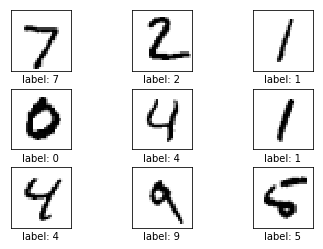

In [5]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = np.argmax(data.test.labels[0:9],1)

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)


### 1.显示所有操作节点
### 2.显示name_scope，集合
### 3.显示图片
### 4.显示损失函数和准确率
### 5.显示直方图📊（权重、偏差等）
### 6.不同学习率等参数的学习率变化
### 7.embedding将数据投射到3D图中

In [6]:


# define convolutional layer function
def conv_fun(name,input,input_channels,output_channels):
    # collect all nodes bellow
    with tf.name_scope(name):
        # w for weights
        w = tf.Variable(tf.truncated_normal(stddev=0.5,shape=[5,5,input_channels,output_channels]),name="conv_w")
        # b for biases
        b = tf.Variable(tf.constant(0.5,shape=[output_channels]),name="conv_b")
        # summary histogram of w & b
        tf.summary.histogram("conv_w",w)
        tf.summary.histogram("conv_b",b)
        # convolute 
        conv_layer = tf.nn.conv2d(
            input = input,
            filter = w,
            strides = [1,1,1,1],
            padding="SAME",
            name="conv_op"
        )

        # add biases
        conv_layer = tf.add(conv_layer,b,name="conv_add")
        # relu
        conv_layer = tf.nn.relu(conv_layer,name="conv_relu")
    
        return conv_layer

# define pooling layer function
def pool_fun(name,input):
    # collect all nodes bellow
    with tf.name_scope(name):
        # max pool
        pool_layer = tf.nn.max_pool(
            value = input,
            ksize = [1,2,2,1],
            strides = [1,2,2,1],
            padding="SAME",
            name = "pool_op"
        )
        return pool_layer


#define fully connected layer function     
def fl_fun(name,input,input_channels,output_channels):
    # collect all nodes bellow    
    with tf.name_scope(name):
        # weights & biases
        w = tf.Variable(tf.truncated_normal(stddev=0.5,shape=[input_channels,output_channels]),name="fl_w")
        b = tf.Variable(tf.constant(0.5,shape=[output_channels]),name="fl_b")
        # summary histogram of w & b
        tf.summary.histogram("fl_w",w)
        tf.summary.histogram("fl_b",b)
        # add biases
        fl = tf.add(tf.matmul(input,w),b,name = "fl_add")
        
        return fl


In [7]:
# generate different string
def generate(learning_rate,use_two_conv,use_two_fl):
    str_a = 2 if use_two_conv else 1
    str_b = 2 if use_two_fl else 1
    return "lr_%s,conv=%s,fl=%s" % (learning_rate,str_a,str_b)

In [8]:
# main model to evaluate different conditions 
def minst_model(lr,use_two_conv,use_two_fl):
    # must reset
    tf.reset_default_graph()
    # x for input 
    x = tf.placeholder(tf.float32,[None,784],name="x")
    # reshape x to NHWC format matrix
    x_reshape = tf.reshape(x,[-1,28,28,1],name="x_reshape")
    # summary input images
    tf.summary.image("input_images",x_reshape)
    
    # use two convolutional layers
    if use_two_conv:
        # conv1,shape :[-1,28,28,32]
        conv1 = conv_fun("conv1",x_reshape,1,32)    
        # pool1 ,shape: [-,14,14,32]
        pool1 = pool_fun("pool1",conv1)
        # conv2 ,shape:[-1,14,14,64]
        conv2 = conv_fun("conv2",pool1,32,64)
        # pool2, shape:[-1,7,7,64]
        pool2 = pool_fun("pool2",conv2)
    # only use one conv layer
    else:
        # conv1,shape :[-1,28,28,64]
        conv1 = conv_fun("conv1",x_reshape,1,64)    
        # pool1 ,shape: [-,14,14,64]
        pool1 = pool_fun("pool1",conv1)
        # pool2, shape:[-1,7,7,64]        
        pool2 = pool_fun("pool2",pool1)

    # flat pool2 to shape [-1,7*7*64]
    flat_layer = tf.reshape(pool2,[-1,7*7*64],name="flat_layer")
    
    # use two fully connected layers
    if use_two_fl:
        # fl_1 (fully connected layer 1) ,shape: [-1,7*7*64,1024]
        fl_1 = fl_fun("fl_1",flat_layer,7*7*64,1024)
        # fl_2, shape [-1,10], as logits
        fl_2 = fl_fun("fl_2",fl_1,1024,10)
    # only use one fl
    else:
        # fl_2, shape [-1,10], as logits
        fl_2 = fl_fun("fl_2",flat_layer,7*7*64,10)
        
        
    # predictive y class
    y_pred_cls = tf.arg_max(fl_2,1)

    
    y_true = tf.placeholder(tf.float32,[None,10],name="y_true")
    y_true_cls = tf.arg_max(y_true,1,name="y_true_cls")

    # cost 
    with tf.name_scope("cost"):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=fl_2,name="cross_entropy")
        cost = tf.reduce_mean(cross_entropy)
        # summary cost 
        tf.summary.scalar("cost",cost)
    # use  AdamOptimizer to train the model    
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    # accuracy    
    with tf.name_scope("accuracy"):
        equals = tf.equal(y_pred_cls,y_true_cls)
        accuracy = tf.reduce_mean(tf.cast(equals,dtype=tf.float32))
        # summary accuracy
        tf.summary.scalar("accuracy",accuracy)
        
    # initial session and variables
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    # merge all summaries
    summary_merged = tf.summary.merge_all()
    # write graph and summaries to train writer
    train_writer = tf.summary.FileWriter('./log/train_'+generate(lr,use_two_conv,use_two_fl)    ,graph=session.graph)
    # writw summaries to test writer
    test_writer = tf.summary.FileWriter('./log/test_'+generate(lr,use_two_conv,use_two_fl) )
    
    batch_size = 100;
    with tf.name_scope("train_iterals"):
        for i in range(6000):
            batch = data.train.next_batch(batch_size)
            feed_dict_batch = {x:batch[0],y_true:batch[1]}
            print i
            if i % 5 == 0:
                s,acc =  session.run([summary_merged,accuracy],feed_dict=feed_dict_batch)
                train_writer.add_summary(s,i)
                print 'Train_'+generate(lr,use_two_conv,use_two_fl)+"acc:{:0.1%}".format(acc)
            if i % 10 == 0:
                feed_dict_test = {
                    x : data.test.images,
                    y_true: data.test.labels
                }
                s,acc = session.run([summary_merged,accuracy],feed_dict=feed_dict_test)
                test_writer.add_summary(s,i)
                print 'Test_'+generate(lr,use_two_conv,use_two_fl)+" acc:{:0.1%}".format(acc)
            
            
            session.run(optimizer,feed_dict=feed_dict_batch)    

    

In [9]:
# different conditions
# learning rate in [0.001,0.0001]
for lr in [0.001,0.0001]:
    # use one or two conv layers
    for use_two_conv in [True,False]:
        # use one or two fl
        for use_two_fl in [True,False]:
            # start model , and evaluate it
            minst_model(lr,use_two_conv,use_two_fl)

0
Train_lr_0.001,conv=2,fl=2acc:11.0%
Test_lr_0.001,conv=2,fl=2 acc:9.7%
1
2
3
4
5
Train_lr_0.001,conv=2,fl=2acc:11.0%
6
7
8
9
10
Train_lr_0.001,conv=2,fl=2acc:33.0%
Test_lr_0.001,conv=2,fl=2 acc:25.2%
11
12
13
14
15
Train_lr_0.001,conv=2,fl=2acc:48.0%
16
17
18
19
20
Train_lr_0.001,conv=2,fl=2acc:45.0%
Test_lr_0.001,conv=2,fl=2 acc:45.6%
21
22
23
24
25
Train_lr_0.001,conv=2,fl=2acc:52.0%
26
27
28
29
30
Train_lr_0.001,conv=2,fl=2acc:76.0%
Test_lr_0.001,conv=2,fl=2 acc:69.7%
31
32
33
34
35
Train_lr_0.001,conv=2,fl=2acc:66.0%
36
37
38
39
40
Train_lr_0.001,conv=2,fl=2acc:86.0%
Test_lr_0.001,conv=2,fl=2 acc:72.7%
41
42
43
44
45
Train_lr_0.001,conv=2,fl=2acc:84.0%
46
47
48
49
50
Train_lr_0.001,conv=2,fl=2acc:78.0%
Test_lr_0.001,conv=2,fl=2 acc:82.0%
51
52
53
54
55
Train_lr_0.001,conv=2,fl=2acc:77.0%
56
57
58
59
60
Train_lr_0.001,conv=2,fl=2acc:80.0%
Test_lr_0.001,conv=2,fl=2 acc:82.3%
61
62
63
64
65
Train_lr_0.001,conv=2,fl=2acc:88.0%
66
67
68
69
70
Train_lr_0.001,conv=2,fl=2acc:90.0%
Test_l

Test_lr_0.001,conv=2,fl=2 acc:93.8%
561
562
563
564
565
Train_lr_0.001,conv=2,fl=2acc:97.0%
566
567
568
569
570
Train_lr_0.001,conv=2,fl=2acc:94.0%
Test_lr_0.001,conv=2,fl=2 acc:94.8%
571
572
573
574
575
Train_lr_0.001,conv=2,fl=2acc:94.0%
576
577
578
579
580
Train_lr_0.001,conv=2,fl=2acc:97.0%
Test_lr_0.001,conv=2,fl=2 acc:95.8%
581
582
583
584
585
Train_lr_0.001,conv=2,fl=2acc:94.0%
586
587
588
589
590
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:95.8%
591
592
593
594
595
Train_lr_0.001,conv=2,fl=2acc:93.0%
596
597
598
599
600
Train_lr_0.001,conv=2,fl=2acc:96.0%
Test_lr_0.001,conv=2,fl=2 acc:96.0%
601
602
603
604
605
Train_lr_0.001,conv=2,fl=2acc:94.0%
606
607
608
609
610
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:94.7%
611
612
613
614
615
Train_lr_0.001,conv=2,fl=2acc:91.0%
616
617
618
619
620
Train_lr_0.001,conv=2,fl=2acc:97.0%
Test_lr_0.001,conv=2,fl=2 acc:95.6%
621
622
623
624
625
Train_lr_0.001,conv=2,fl=2acc:98.0%
626
627
628
629
630


1107
1108
1109
1110
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:96.7%
1111
1112
1113
1114
1115
Train_lr_0.001,conv=2,fl=2acc:99.0%
1116
1117
1118
1119
1120
Train_lr_0.001,conv=2,fl=2acc:95.0%
Test_lr_0.001,conv=2,fl=2 acc:96.7%
1121
1122
1123
1124
1125
Train_lr_0.001,conv=2,fl=2acc:99.0%
1126
1127
1128
1129
1130
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:95.6%
1131
1132
1133
1134
1135
Train_lr_0.001,conv=2,fl=2acc:96.0%
1136
1137
1138
1139
1140
Train_lr_0.001,conv=2,fl=2acc:97.0%
Test_lr_0.001,conv=2,fl=2 acc:95.1%
1141
1142
1143
1144
1145
Train_lr_0.001,conv=2,fl=2acc:99.0%
1146
1147
1148
1149
1150
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:96.6%
1151
1152
1153
1154
1155
Train_lr_0.001,conv=2,fl=2acc:97.0%
1156
1157
1158
1159
1160
Train_lr_0.001,conv=2,fl=2acc:93.0%
Test_lr_0.001,conv=2,fl=2 acc:96.2%
1161
1162
1163
1164
1165
Train_lr_0.001,conv=2,fl=2acc:97.0%
1166
1167
1168
1169
1170
Train_lr_0.001,conv=2,fl=2acc:97

1627
1628
1629
1630
Train_lr_0.001,conv=2,fl=2acc:96.0%
Test_lr_0.001,conv=2,fl=2 acc:97.3%
1631
1632
1633
1634
1635
Train_lr_0.001,conv=2,fl=2acc:97.0%
1636
1637
1638
1639
1640
Train_lr_0.001,conv=2,fl=2acc:97.0%
Test_lr_0.001,conv=2,fl=2 acc:96.4%
1641
1642
1643
1644
1645
Train_lr_0.001,conv=2,fl=2acc:92.0%
1646
1647
1648
1649
1650
Train_lr_0.001,conv=2,fl=2acc:95.0%
Test_lr_0.001,conv=2,fl=2 acc:96.3%
1651
1652
1653
1654
1655
Train_lr_0.001,conv=2,fl=2acc:97.0%
1656
1657
1658
1659
1660
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.3%
1661
1662
1663
1664
1665
Train_lr_0.001,conv=2,fl=2acc:98.0%
1666
1667
1668
1669
1670
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.1%
1671
1672
1673
1674
1675
Train_lr_0.001,conv=2,fl=2acc:100.0%
1676
1677
1678
1679
1680
Train_lr_0.001,conv=2,fl=2acc:97.0%
Test_lr_0.001,conv=2,fl=2 acc:96.7%
1681
1682
1683
1684
1685
Train_lr_0.001,conv=2,fl=2acc:96.0%
1686
1687
1688
1689
1690
Train_lr_0.001,conv=2,fl=2acc:9

2146
2147
2148
2149
2150
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.0%
2151
2152
2153
2154
2155
Train_lr_0.001,conv=2,fl=2acc:95.0%
2156
2157
2158
2159
2160
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.4%
2161
2162
2163
2164
2165
Train_lr_0.001,conv=2,fl=2acc:99.0%
2166
2167
2168
2169
2170
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.4%
2171
2172
2173
2174
2175
Train_lr_0.001,conv=2,fl=2acc:97.0%
2176
2177
2178
2179
2180
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.2%
2181
2182
2183
2184
2185
Train_lr_0.001,conv=2,fl=2acc:96.0%
2186
2187
2188
2189
2190
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.1%
2191
2192
2193
2194
2195
Train_lr_0.001,conv=2,fl=2acc:99.0%
2196
2197
2198
2199
2200
Train_lr_0.001,conv=2,fl=2acc:96.0%
Test_lr_0.001,conv=2,fl=2 acc:97.1%
2201
2202
2203
2204
2205
Train_lr_0.001,conv=2,fl=2acc:98.0%
2206
2207
2208
2209
2210
Train_lr_0.001,conv=2,fl=2a

2667
2668
2669
2670
Train_lr_0.001,conv=2,fl=2acc:96.0%
Test_lr_0.001,conv=2,fl=2 acc:97.1%
2671
2672
2673
2674
2675
Train_lr_0.001,conv=2,fl=2acc:95.0%
2676
2677
2678
2679
2680
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.2%
2681
2682
2683
2684
2685
Train_lr_0.001,conv=2,fl=2acc:97.0%
2686
2687
2688
2689
2690
Train_lr_0.001,conv=2,fl=2acc:96.0%
Test_lr_0.001,conv=2,fl=2 acc:97.1%
2691
2692
2693
2694
2695
Train_lr_0.001,conv=2,fl=2acc:96.0%
2696
2697
2698
2699
2700
Train_lr_0.001,conv=2,fl=2acc:100.0%
Test_lr_0.001,conv=2,fl=2 acc:97.2%
2701
2702
2703
2704
2705
Train_lr_0.001,conv=2,fl=2acc:92.0%
2706
2707
2708
2709
2710
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.5%
2711
2712
2713
2714
2715
Train_lr_0.001,conv=2,fl=2acc:96.0%
2716
2717
2718
2719
2720
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.3%
2721
2722
2723
2724
2725
Train_lr_0.001,conv=2,fl=2acc:98.0%
2726
2727
2728
2729
2730
Train_lr_0.001,conv=2,fl=2acc:9

3187
3188
3189
3190
Train_lr_0.001,conv=2,fl=2acc:97.0%
Test_lr_0.001,conv=2,fl=2 acc:97.1%
3191
3192
3193
3194
3195
Train_lr_0.001,conv=2,fl=2acc:97.0%
3196
3197
3198
3199
3200
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.0%
3201
3202
3203
3204
3205
Train_lr_0.001,conv=2,fl=2acc:99.0%
3206
3207
3208
3209
3210
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.4%
3211
3212
3213
3214
3215
Train_lr_0.001,conv=2,fl=2acc:97.0%
3216
3217
3218
3219
3220
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.0%
3221
3222
3223
3224
3225
Train_lr_0.001,conv=2,fl=2acc:98.0%
3226
3227
3228
3229
3230
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.0%
3231
3232
3233
3234
3235
Train_lr_0.001,conv=2,fl=2acc:99.0%
3236
3237
3238
3239
3240
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.3%
3241
3242
3243
3244
3245
Train_lr_0.001,conv=2,fl=2acc:95.0%
3246
3247
3248
3249
3250
Train_lr_0.001,conv=2,fl=2acc:95

3705
Train_lr_0.001,conv=2,fl=2acc:99.0%
3706
3707
3708
3709
3710
Train_lr_0.001,conv=2,fl=2acc:97.0%
Test_lr_0.001,conv=2,fl=2 acc:97.5%
3711
3712
3713
3714
3715
Train_lr_0.001,conv=2,fl=2acc:100.0%
3716
3717
3718
3719
3720
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.0%
3721
3722
3723
3724
3725
Train_lr_0.001,conv=2,fl=2acc:97.0%
3726
3727
3728
3729
3730
Train_lr_0.001,conv=2,fl=2acc:97.0%
Test_lr_0.001,conv=2,fl=2 acc:97.5%
3731
3732
3733
3734
3735
Train_lr_0.001,conv=2,fl=2acc:97.0%
3736
3737
3738
3739
3740
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.6%
3741
3742
3743
3744
3745
Train_lr_0.001,conv=2,fl=2acc:100.0%
3746
3747
3748
3749
3750
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.4%
3751
3752
3753
3754
3755
Train_lr_0.001,conv=2,fl=2acc:98.0%
3756
3757
3758
3759
3760
Train_lr_0.001,conv=2,fl=2acc:97.0%
Test_lr_0.001,conv=2,fl=2 acc:97.5%
3761
3762
3763
3764
3765
Train_lr_0.001,conv=2,fl=2acc:97.0%
3766
3767

4221
4222
4223
4224
4225
Train_lr_0.001,conv=2,fl=2acc:99.0%
4226
4227
4228
4229
4230
Train_lr_0.001,conv=2,fl=2acc:100.0%
Test_lr_0.001,conv=2,fl=2 acc:97.7%
4231
4232
4233
4234
4235
Train_lr_0.001,conv=2,fl=2acc:99.0%
4236
4237
4238
4239
4240
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.9%
4241
4242
4243
4244
4245
Train_lr_0.001,conv=2,fl=2acc:99.0%
4246
4247
4248
4249
4250
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.6%
4251
4252
4253
4254
4255
Train_lr_0.001,conv=2,fl=2acc:98.0%
4256
4257
4258
4259
4260
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.6%
4261
4262
4263
4264
4265
Train_lr_0.001,conv=2,fl=2acc:97.0%
4266
4267
4268
4269
4270
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.5%
4271
4272
4273
4274
4275
Train_lr_0.001,conv=2,fl=2acc:97.0%
4276
4277
4278
4279
4280
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.4%
4281
4282
4283
4284
4285
Train_lr_0.001,conv=2,fl=2

Test_lr_0.001,conv=2,fl=2 acc:97.7%
4741
4742
4743
4744
4745
Train_lr_0.001,conv=2,fl=2acc:99.0%
4746
4747
4748
4749
4750
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.4%
4751
4752
4753
4754
4755
Train_lr_0.001,conv=2,fl=2acc:97.0%
4756
4757
4758
4759
4760
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.7%
4761
4762
4763
4764
4765
Train_lr_0.001,conv=2,fl=2acc:99.0%
4766
4767
4768
4769
4770
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.4%
4771
4772
4773
4774
4775
Train_lr_0.001,conv=2,fl=2acc:97.0%
4776
4777
4778
4779
4780
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.8%
4781
4782
4783
4784
4785
Train_lr_0.001,conv=2,fl=2acc:99.0%
4786
4787
4788
4789
4790
Train_lr_0.001,conv=2,fl=2acc:100.0%
Test_lr_0.001,conv=2,fl=2 acc:97.6%
4791
4792
4793
4794
4795
Train_lr_0.001,conv=2,fl=2acc:98.0%
4796
4797
4798
4799
4800
Train_lr_0.001,conv=2,fl=2acc:100.0%
Test_lr_0.001,conv=2,fl=2 acc:97.7%
4801
4802
4803

5258
5259
5260
Train_lr_0.001,conv=2,fl=2acc:100.0%
Test_lr_0.001,conv=2,fl=2 acc:97.5%
5261
5262
5263
5264
5265
Train_lr_0.001,conv=2,fl=2acc:99.0%
5266
5267
5268
5269
5270
Train_lr_0.001,conv=2,fl=2acc:98.0%
Test_lr_0.001,conv=2,fl=2 acc:97.5%
5271
5272
5273
5274
5275
Train_lr_0.001,conv=2,fl=2acc:100.0%
5276
5277
5278
5279
5280
Train_lr_0.001,conv=2,fl=2acc:100.0%
Test_lr_0.001,conv=2,fl=2 acc:97.6%
5281
5282
5283
5284
5285
Train_lr_0.001,conv=2,fl=2acc:100.0%
5286
5287
5288
5289
5290
Train_lr_0.001,conv=2,fl=2acc:100.0%
Test_lr_0.001,conv=2,fl=2 acc:97.5%
5291
5292
5293
5294
5295
Train_lr_0.001,conv=2,fl=2acc:97.0%
5296
5297
5298
5299
5300
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.7%
5301
5302
5303
5304
5305
Train_lr_0.001,conv=2,fl=2acc:98.0%
5306
5307
5308
5309
5310
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.9%
5311
5312
5313
5314
5315
Train_lr_0.001,conv=2,fl=2acc:97.0%
5316
5317
5318
5319
5320
Train_lr_0.001,conv=2,fl=2acc:97

5774
5775
Train_lr_0.001,conv=2,fl=2acc:97.0%
5776
5777
5778
5779
5780
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.6%
5781
5782
5783
5784
5785
Train_lr_0.001,conv=2,fl=2acc:97.0%
5786
5787
5788
5789
5790
Train_lr_0.001,conv=2,fl=2acc:97.0%
Test_lr_0.001,conv=2,fl=2 acc:97.5%
5791
5792
5793
5794
5795
Train_lr_0.001,conv=2,fl=2acc:100.0%
5796
5797
5798
5799
5800
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.9%
5801
5802
5803
5804
5805
Train_lr_0.001,conv=2,fl=2acc:100.0%
5806
5807
5808
5809
5810
Train_lr_0.001,conv=2,fl=2acc:100.0%
Test_lr_0.001,conv=2,fl=2 acc:97.8%
5811
5812
5813
5814
5815
Train_lr_0.001,conv=2,fl=2acc:99.0%
5816
5817
5818
5819
5820
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.7%
5821
5822
5823
5824
5825
Train_lr_0.001,conv=2,fl=2acc:99.0%
5826
5827
5828
5829
5830
Train_lr_0.001,conv=2,fl=2acc:99.0%
Test_lr_0.001,conv=2,fl=2 acc:97.9%
5831
5832
5833
5834
5835
Train_lr_0.001,conv=2,fl=2acc:100.0%
58

Test_lr_0.001,conv=2,fl=1 acc:86.7%
321
322
323
324
325
Train_lr_0.001,conv=2,fl=1acc:83.0%
326
327
328
329
330
Train_lr_0.001,conv=2,fl=1acc:88.0%
Test_lr_0.001,conv=2,fl=1 acc:85.9%
331
332
333
334
335
Train_lr_0.001,conv=2,fl=1acc:76.0%
336
337
338
339
340
Train_lr_0.001,conv=2,fl=1acc:83.0%
Test_lr_0.001,conv=2,fl=1 acc:86.4%
341
342
343
344
345
Train_lr_0.001,conv=2,fl=1acc:85.0%
346
347
348
349
350
Train_lr_0.001,conv=2,fl=1acc:84.0%
Test_lr_0.001,conv=2,fl=1 acc:86.3%
351
352
353
354
355
Train_lr_0.001,conv=2,fl=1acc:82.0%
356
357
358
359
360
Train_lr_0.001,conv=2,fl=1acc:86.0%
Test_lr_0.001,conv=2,fl=1 acc:86.9%
361
362
363
364
365
Train_lr_0.001,conv=2,fl=1acc:86.0%
366
367
368
369
370
Train_lr_0.001,conv=2,fl=1acc:86.0%
Test_lr_0.001,conv=2,fl=1 acc:86.7%
371
372
373
374
375
Train_lr_0.001,conv=2,fl=1acc:90.0%
376
377
378
379
380
Train_lr_0.001,conv=2,fl=1acc:86.0%
Test_lr_0.001,conv=2,fl=1 acc:87.7%
381
382
383
384
385
Train_lr_0.001,conv=2,fl=1acc:84.0%
386
387
388
389
390


876
877
878
879
880
Train_lr_0.001,conv=2,fl=1acc:93.0%
Test_lr_0.001,conv=2,fl=1 acc:91.2%
881
882
883
884
885
Train_lr_0.001,conv=2,fl=1acc:94.0%
886
887
888
889
890
Train_lr_0.001,conv=2,fl=1acc:88.0%
Test_lr_0.001,conv=2,fl=1 acc:89.0%
891
892
893
894
895
Train_lr_0.001,conv=2,fl=1acc:90.0%
896
897
898
899
900
Train_lr_0.001,conv=2,fl=1acc:86.0%
Test_lr_0.001,conv=2,fl=1 acc:90.6%
901
902
903
904
905
Train_lr_0.001,conv=2,fl=1acc:94.0%
906
907
908
909
910
Train_lr_0.001,conv=2,fl=1acc:97.0%
Test_lr_0.001,conv=2,fl=1 acc:92.0%
911
912
913
914
915
Train_lr_0.001,conv=2,fl=1acc:88.0%
916
917
918
919
920
Train_lr_0.001,conv=2,fl=1acc:91.0%
Test_lr_0.001,conv=2,fl=1 acc:91.8%
921
922
923
924
925
Train_lr_0.001,conv=2,fl=1acc:92.0%
926
927
928
929
930
Train_lr_0.001,conv=2,fl=1acc:94.0%
Test_lr_0.001,conv=2,fl=1 acc:92.2%
931
932
933
934
935
Train_lr_0.001,conv=2,fl=1acc:95.0%
936
937
938
939
940
Train_lr_0.001,conv=2,fl=1acc:88.0%
Test_lr_0.001,conv=2,fl=1 acc:92.1%
941
942
943
944
945


1402
1403
1404
1405
Train_lr_0.001,conv=2,fl=1acc:96.0%
1406
1407
1408
1409
1410
Train_lr_0.001,conv=2,fl=1acc:90.0%
Test_lr_0.001,conv=2,fl=1 acc:93.3%
1411
1412
1413
1414
1415
Train_lr_0.001,conv=2,fl=1acc:94.0%
1416
1417
1418
1419
1420
Train_lr_0.001,conv=2,fl=1acc:96.0%
Test_lr_0.001,conv=2,fl=1 acc:94.7%
1421
1422
1423
1424
1425
Train_lr_0.001,conv=2,fl=1acc:95.0%
1426
1427
1428
1429
1430
Train_lr_0.001,conv=2,fl=1acc:93.0%
Test_lr_0.001,conv=2,fl=1 acc:94.5%
1431
1432
1433
1434
1435
Train_lr_0.001,conv=2,fl=1acc:95.0%
1436
1437
1438
1439
1440
Train_lr_0.001,conv=2,fl=1acc:92.0%
Test_lr_0.001,conv=2,fl=1 acc:94.6%
1441
1442
1443
1444
1445
Train_lr_0.001,conv=2,fl=1acc:91.0%
1446
1447
1448
1449
1450
Train_lr_0.001,conv=2,fl=1acc:95.0%
Test_lr_0.001,conv=2,fl=1 acc:94.3%
1451
1452
1453
1454
1455
Train_lr_0.001,conv=2,fl=1acc:96.0%
1456
1457
1458
1459
1460
Train_lr_0.001,conv=2,fl=1acc:94.0%
Test_lr_0.001,conv=2,fl=1 acc:94.1%
1461
1462
1463
1464
1465
Train_lr_0.001,conv=2,fl=1acc:95

1922
1923
1924
1925
Train_lr_0.001,conv=2,fl=1acc:93.0%
1926
1927
1928
1929
1930
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:95.3%
1931
1932
1933
1934
1935
Train_lr_0.001,conv=2,fl=1acc:97.0%
1936
1937
1938
1939
1940
Train_lr_0.001,conv=2,fl=1acc:95.0%
Test_lr_0.001,conv=2,fl=1 acc:95.1%
1941
1942
1943
1944
1945
Train_lr_0.001,conv=2,fl=1acc:93.0%
1946
1947
1948
1949
1950
Train_lr_0.001,conv=2,fl=1acc:98.0%
Test_lr_0.001,conv=2,fl=1 acc:95.1%
1951
1952
1953
1954
1955
Train_lr_0.001,conv=2,fl=1acc:96.0%
1956
1957
1958
1959
1960
Train_lr_0.001,conv=2,fl=1acc:95.0%
Test_lr_0.001,conv=2,fl=1 acc:94.4%
1961
1962
1963
1964
1965
Train_lr_0.001,conv=2,fl=1acc:98.0%
1966
1967
1968
1969
1970
Train_lr_0.001,conv=2,fl=1acc:93.0%
Test_lr_0.001,conv=2,fl=1 acc:95.0%
1971
1972
1973
1974
1975
Train_lr_0.001,conv=2,fl=1acc:94.0%
1976
1977
1978
1979
1980
Train_lr_0.001,conv=2,fl=1acc:93.0%
Test_lr_0.001,conv=2,fl=1 acc:94.6%
1981
1982
1983
1984
1985
Train_lr_0.001,conv=2,fl=1acc:90

2442
2443
2444
2445
Train_lr_0.001,conv=2,fl=1acc:99.0%
2446
2447
2448
2449
2450
Train_lr_0.001,conv=2,fl=1acc:97.0%
Test_lr_0.001,conv=2,fl=1 acc:96.3%
2451
2452
2453
2454
2455
Train_lr_0.001,conv=2,fl=1acc:96.0%
2456
2457
2458
2459
2460
Train_lr_0.001,conv=2,fl=1acc:96.0%
Test_lr_0.001,conv=2,fl=1 acc:95.6%
2461
2462
2463
2464
2465
Train_lr_0.001,conv=2,fl=1acc:95.0%
2466
2467
2468
2469
2470
Train_lr_0.001,conv=2,fl=1acc:96.0%
Test_lr_0.001,conv=2,fl=1 acc:96.0%
2471
2472
2473
2474
2475
Train_lr_0.001,conv=2,fl=1acc:91.0%
2476
2477
2478
2479
2480
Train_lr_0.001,conv=2,fl=1acc:96.0%
Test_lr_0.001,conv=2,fl=1 acc:94.6%
2481
2482
2483
2484
2485
Train_lr_0.001,conv=2,fl=1acc:97.0%
2486
2487
2488
2489
2490
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:95.2%
2491
2492
2493
2494
2495
Train_lr_0.001,conv=2,fl=1acc:96.0%
2496
2497
2498
2499
2500
Train_lr_0.001,conv=2,fl=1acc:96.0%
Test_lr_0.001,conv=2,fl=1 acc:95.9%
2501
2502
2503
2504
2505
Train_lr_0.001,conv=2,fl=1acc:10

2962
2963
2964
2965
Train_lr_0.001,conv=2,fl=1acc:97.0%
2966
2967
2968
2969
2970
Train_lr_0.001,conv=2,fl=1acc:92.0%
Test_lr_0.001,conv=2,fl=1 acc:96.1%
2971
2972
2973
2974
2975
Train_lr_0.001,conv=2,fl=1acc:96.0%
2976
2977
2978
2979
2980
Train_lr_0.001,conv=2,fl=1acc:96.0%
Test_lr_0.001,conv=2,fl=1 acc:95.4%
2981
2982
2983
2984
2985
Train_lr_0.001,conv=2,fl=1acc:97.0%
2986
2987
2988
2989
2990
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:96.6%
2991
2992
2993
2994
2995
Train_lr_0.001,conv=2,fl=1acc:95.0%
2996
2997
2998
2999
3000
Train_lr_0.001,conv=2,fl=1acc:98.0%
Test_lr_0.001,conv=2,fl=1 acc:96.7%
3001
3002
3003
3004
3005
Train_lr_0.001,conv=2,fl=1acc:98.0%
3006
3007
3008
3009
3010
Train_lr_0.001,conv=2,fl=1acc:95.0%
Test_lr_0.001,conv=2,fl=1 acc:96.6%
3011
3012
3013
3014
3015
Train_lr_0.001,conv=2,fl=1acc:97.0%
3016
3017
3018
3019
3020
Train_lr_0.001,conv=2,fl=1acc:100.0%
Test_lr_0.001,conv=2,fl=1 acc:96.4%
3021
3022
3023
3024
3025
Train_lr_0.001,conv=2,fl=1acc:9

3481
3482
3483
3484
3485
Train_lr_0.001,conv=2,fl=1acc:100.0%
3486
3487
3488
3489
3490
Train_lr_0.001,conv=2,fl=1acc:97.0%
Test_lr_0.001,conv=2,fl=1 acc:97.0%
3491
3492
3493
3494
3495
Train_lr_0.001,conv=2,fl=1acc:98.0%
3496
3497
3498
3499
3500
Train_lr_0.001,conv=2,fl=1acc:98.0%
Test_lr_0.001,conv=2,fl=1 acc:97.0%
3501
3502
3503
3504
3505
Train_lr_0.001,conv=2,fl=1acc:97.0%
3506
3507
3508
3509
3510
Train_lr_0.001,conv=2,fl=1acc:98.0%
Test_lr_0.001,conv=2,fl=1 acc:97.1%
3511
3512
3513
3514
3515
Train_lr_0.001,conv=2,fl=1acc:97.0%
3516
3517
3518
3519
3520
Train_lr_0.001,conv=2,fl=1acc:96.0%
Test_lr_0.001,conv=2,fl=1 acc:96.8%
3521
3522
3523
3524
3525
Train_lr_0.001,conv=2,fl=1acc:95.0%
3526
3527
3528
3529
3530
Train_lr_0.001,conv=2,fl=1acc:96.0%
Test_lr_0.001,conv=2,fl=1 acc:96.9%
3531
3532
3533
3534
3535
Train_lr_0.001,conv=2,fl=1acc:99.0%
3536
3537
3538
3539
3540
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:96.7%
3541
3542
3543
3544
3545
Train_lr_0.001,conv=2,fl=1

4002
4003
4004
4005
Train_lr_0.001,conv=2,fl=1acc:99.0%
4006
4007
4008
4009
4010
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:96.7%
4011
4012
4013
4014
4015
Train_lr_0.001,conv=2,fl=1acc:100.0%
4016
4017
4018
4019
4020
Train_lr_0.001,conv=2,fl=1acc:96.0%
Test_lr_0.001,conv=2,fl=1 acc:96.5%
4021
4022
4023
4024
4025
Train_lr_0.001,conv=2,fl=1acc:96.0%
4026
4027
4028
4029
4030
Train_lr_0.001,conv=2,fl=1acc:100.0%
Test_lr_0.001,conv=2,fl=1 acc:97.2%
4031
4032
4033
4034
4035
Train_lr_0.001,conv=2,fl=1acc:99.0%
4036
4037
4038
4039
4040
Train_lr_0.001,conv=2,fl=1acc:97.0%
Test_lr_0.001,conv=2,fl=1 acc:96.5%
4041
4042
4043
4044
4045
Train_lr_0.001,conv=2,fl=1acc:99.0%
4046
4047
4048
4049
4050
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:97.2%
4051
4052
4053
4054
4055
Train_lr_0.001,conv=2,fl=1acc:99.0%
4056
4057
4058
4059
4060
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:96.8%
4061
4062
4063
4064
4065
Train_lr_0.001,conv=2,fl=1acc:

4521
4522
4523
4524
4525
Train_lr_0.001,conv=2,fl=1acc:96.0%
4526
4527
4528
4529
4530
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:96.9%
4531
4532
4533
4534
4535
Train_lr_0.001,conv=2,fl=1acc:97.0%
4536
4537
4538
4539
4540
Train_lr_0.001,conv=2,fl=1acc:97.0%
Test_lr_0.001,conv=2,fl=1 acc:97.4%
4541
4542
4543
4544
4545
Train_lr_0.001,conv=2,fl=1acc:99.0%
4546
4547
4548
4549
4550
Train_lr_0.001,conv=2,fl=1acc:98.0%
Test_lr_0.001,conv=2,fl=1 acc:97.5%
4551
4552
4553
4554
4555
Train_lr_0.001,conv=2,fl=1acc:99.0%
4556
4557
4558
4559
4560
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:96.7%
4561
4562
4563
4564
4565
Train_lr_0.001,conv=2,fl=1acc:99.0%
4566
4567
4568
4569
4570
Train_lr_0.001,conv=2,fl=1acc:100.0%
Test_lr_0.001,conv=2,fl=1 acc:97.3%
4571
4572
4573
4574
4575
Train_lr_0.001,conv=2,fl=1acc:99.0%
4576
4577
4578
4579
4580
Train_lr_0.001,conv=2,fl=1acc:98.0%
Test_lr_0.001,conv=2,fl=1 acc:96.9%
4581
4582
4583
4584
4585
Train_lr_0.001,conv=2,fl=1

5041
5042
5043
5044
5045
Train_lr_0.001,conv=2,fl=1acc:95.0%
5046
5047
5048
5049
5050
Train_lr_0.001,conv=2,fl=1acc:97.0%
Test_lr_0.001,conv=2,fl=1 acc:97.0%
5051
5052
5053
5054
5055
Train_lr_0.001,conv=2,fl=1acc:98.0%
5056
5057
5058
5059
5060
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:97.3%
5061
5062
5063
5064
5065
Train_lr_0.001,conv=2,fl=1acc:98.0%
5066
5067
5068
5069
5070
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:97.3%
5071
5072
5073
5074
5075
Train_lr_0.001,conv=2,fl=1acc:96.0%
5076
5077
5078
5079
5080
Train_lr_0.001,conv=2,fl=1acc:100.0%
Test_lr_0.001,conv=2,fl=1 acc:97.5%
5081
5082
5083
5084
5085
Train_lr_0.001,conv=2,fl=1acc:98.0%
5086
5087
5088
5089
5090
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:97.1%
5091
5092
5093
5094
5095
Train_lr_0.001,conv=2,fl=1acc:99.0%
5096
5097
5098
5099
5100
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:97.4%
5101
5102
5103
5104
5105
Train_lr_0.001,conv=2,fl=1

Test_lr_0.001,conv=2,fl=1 acc:97.2%
5561
5562
5563
5564
5565
Train_lr_0.001,conv=2,fl=1acc:99.0%
5566
5567
5568
5569
5570
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:97.3%
5571
5572
5573
5574
5575
Train_lr_0.001,conv=2,fl=1acc:97.0%
5576
5577
5578
5579
5580
Train_lr_0.001,conv=2,fl=1acc:98.0%
Test_lr_0.001,conv=2,fl=1 acc:97.8%
5581
5582
5583
5584
5585
Train_lr_0.001,conv=2,fl=1acc:98.0%
5586
5587
5588
5589
5590
Train_lr_0.001,conv=2,fl=1acc:99.0%
Test_lr_0.001,conv=2,fl=1 acc:97.8%
5591
5592
5593
5594
5595
Train_lr_0.001,conv=2,fl=1acc:100.0%
5596
5597
5598
5599
5600
Train_lr_0.001,conv=2,fl=1acc:98.0%
Test_lr_0.001,conv=2,fl=1 acc:97.0%
5601
5602
5603
5604
5605
Train_lr_0.001,conv=2,fl=1acc:98.0%
5606
5607
5608
5609
5610
Train_lr_0.001,conv=2,fl=1acc:98.0%
Test_lr_0.001,conv=2,fl=1 acc:97.3%
5611
5612
5613
5614
5615
Train_lr_0.001,conv=2,fl=1acc:100.0%
5616
5617
5618
5619
5620
Train_lr_0.001,conv=2,fl=1acc:97.0%
Test_lr_0.001,conv=2,fl=1 acc:97.5%
5621
5622
5623

Test_lr_0.001,conv=1,fl=2 acc:79.4%
91
92
93
94
95
Train_lr_0.001,conv=1,fl=2acc:77.0%
96
97
98
99
100
Train_lr_0.001,conv=1,fl=2acc:84.0%
Test_lr_0.001,conv=1,fl=2 acc:84.4%
101
102
103
104
105
Train_lr_0.001,conv=1,fl=2acc:83.0%
106
107
108
109
110
Train_lr_0.001,conv=1,fl=2acc:83.0%
Test_lr_0.001,conv=1,fl=2 acc:83.2%
111
112
113
114
115
Train_lr_0.001,conv=1,fl=2acc:81.0%
116
117
118
119
120
Train_lr_0.001,conv=1,fl=2acc:86.0%
Test_lr_0.001,conv=1,fl=2 acc:84.9%
121
122
123
124
125
Train_lr_0.001,conv=1,fl=2acc:84.0%
126
127
128
129
130
Train_lr_0.001,conv=1,fl=2acc:85.0%
Test_lr_0.001,conv=1,fl=2 acc:83.8%
131
132
133
134
135
Train_lr_0.001,conv=1,fl=2acc:85.0%
136
137
138
139
140
Train_lr_0.001,conv=1,fl=2acc:86.0%
Test_lr_0.001,conv=1,fl=2 acc:86.3%
141
142
143
144
145
Train_lr_0.001,conv=1,fl=2acc:88.0%
146
147
148
149
150
Train_lr_0.001,conv=1,fl=2acc:82.0%
Test_lr_0.001,conv=1,fl=2 acc:86.0%
151
152
153
154
155
Train_lr_0.001,conv=1,fl=2acc:89.0%
156
157
158
159
160
Train_lr_

647
648
649
650
Train_lr_0.001,conv=1,fl=2acc:89.0%
Test_lr_0.001,conv=1,fl=2 acc:87.7%
651
652
653
654
655
Train_lr_0.001,conv=1,fl=2acc:90.0%
656
657
658
659
660
Train_lr_0.001,conv=1,fl=2acc:98.0%
Test_lr_0.001,conv=1,fl=2 acc:91.9%
661
662
663
664
665
Train_lr_0.001,conv=1,fl=2acc:88.0%
666
667
668
669
670
Train_lr_0.001,conv=1,fl=2acc:93.0%
Test_lr_0.001,conv=1,fl=2 acc:92.2%
671
672
673
674
675
Train_lr_0.001,conv=1,fl=2acc:92.0%
676
677
678
679
680
Train_lr_0.001,conv=1,fl=2acc:91.0%
Test_lr_0.001,conv=1,fl=2 acc:92.2%
681
682
683
684
685
Train_lr_0.001,conv=1,fl=2acc:94.0%
686
687
688
689
690
Train_lr_0.001,conv=1,fl=2acc:90.0%
Test_lr_0.001,conv=1,fl=2 acc:94.5%
691
692
693
694
695
Train_lr_0.001,conv=1,fl=2acc:94.0%
696
697
698
699
700
Train_lr_0.001,conv=1,fl=2acc:90.0%
Test_lr_0.001,conv=1,fl=2 acc:89.4%
701
702
703
704
705
Train_lr_0.001,conv=1,fl=2acc:94.0%
706
707
708
709
710
Train_lr_0.001,conv=1,fl=2acc:89.0%
Test_lr_0.001,conv=1,fl=2 acc:92.2%
711
712
713
714
715
Trai

Train_lr_0.001,conv=1,fl=2acc:94.0%
Test_lr_0.001,conv=1,fl=2 acc:95.5%
1191
1192
1193
1194
1195
Train_lr_0.001,conv=1,fl=2acc:97.0%
1196
1197
1198
1199
1200
Train_lr_0.001,conv=1,fl=2acc:92.0%
Test_lr_0.001,conv=1,fl=2 acc:94.7%
1201
1202
1203
1204
1205
Train_lr_0.001,conv=1,fl=2acc:97.0%
1206
1207
1208
1209
1210
Train_lr_0.001,conv=1,fl=2acc:96.0%
Test_lr_0.001,conv=1,fl=2 acc:96.4%
1211
1212
1213
1214
1215
Train_lr_0.001,conv=1,fl=2acc:91.0%
1216
1217
1218
1219
1220
Train_lr_0.001,conv=1,fl=2acc:89.0%
Test_lr_0.001,conv=1,fl=2 acc:92.7%
1221
1222
1223
1224
1225
Train_lr_0.001,conv=1,fl=2acc:92.0%
1226
1227
1228
1229
1230
Train_lr_0.001,conv=1,fl=2acc:97.0%
Test_lr_0.001,conv=1,fl=2 acc:96.6%
1231
1232
1233
1234
1235
Train_lr_0.001,conv=1,fl=2acc:97.0%
1236
1237
1238
1239
1240
Train_lr_0.001,conv=1,fl=2acc:95.0%
Test_lr_0.001,conv=1,fl=2 acc:94.7%
1241
1242
1243
1244
1245
Train_lr_0.001,conv=1,fl=2acc:97.0%
1246
1247
1248
1249
1250
Train_lr_0.001,conv=1,fl=2acc:93.0%
Test_lr_0.001,co

1707
1708
1709
1710
Train_lr_0.001,conv=1,fl=2acc:95.0%
Test_lr_0.001,conv=1,fl=2 acc:96.6%
1711
1712
1713
1714
1715
Train_lr_0.001,conv=1,fl=2acc:97.0%
1716
1717
1718
1719
1720
Train_lr_0.001,conv=1,fl=2acc:97.0%
Test_lr_0.001,conv=1,fl=2 acc:96.9%
1721
1722
1723
1724
1725
Train_lr_0.001,conv=1,fl=2acc:96.0%
1726
1727
1728
1729
1730
Train_lr_0.001,conv=1,fl=2acc:91.0%
Test_lr_0.001,conv=1,fl=2 acc:94.9%
1731
1732
1733
1734
1735
Train_lr_0.001,conv=1,fl=2acc:94.0%
1736
1737
1738
1739
1740
Train_lr_0.001,conv=1,fl=2acc:98.0%
Test_lr_0.001,conv=1,fl=2 acc:96.8%
1741
1742
1743
1744
1745
Train_lr_0.001,conv=1,fl=2acc:98.0%
1746
1747
1748
1749
1750
Train_lr_0.001,conv=1,fl=2acc:95.0%
Test_lr_0.001,conv=1,fl=2 acc:96.3%
1751
1752
1753
1754
1755
Train_lr_0.001,conv=1,fl=2acc:92.0%
1756
1757
1758
1759
1760
Train_lr_0.001,conv=1,fl=2acc:94.0%
Test_lr_0.001,conv=1,fl=2 acc:93.3%
1761
1762
1763
1764
1765
Train_lr_0.001,conv=1,fl=2acc:96.0%
1766
1767
1768
1769
1770
Train_lr_0.001,conv=1,fl=2acc:97

2227
2228
2229
2230
Train_lr_0.001,conv=1,fl=2acc:95.0%
Test_lr_0.001,conv=1,fl=2 acc:96.8%
2231
2232
2233
2234
2235
Train_lr_0.001,conv=1,fl=2acc:95.0%
2236
2237
2238
2239
2240
Train_lr_0.001,conv=1,fl=2acc:97.0%
Test_lr_0.001,conv=1,fl=2 acc:95.0%
2241
2242
2243
2244
2245
Train_lr_0.001,conv=1,fl=2acc:92.0%
2246
2247
2248
2249
2250
Train_lr_0.001,conv=1,fl=2acc:95.0%
Test_lr_0.001,conv=1,fl=2 acc:97.3%
2251
2252
2253
2254
2255
Train_lr_0.001,conv=1,fl=2acc:95.0%
2256
2257
2258
2259
2260
Train_lr_0.001,conv=1,fl=2acc:96.0%
Test_lr_0.001,conv=1,fl=2 acc:96.0%
2261
2262
2263
2264
2265
Train_lr_0.001,conv=1,fl=2acc:95.0%
2266
2267
2268
2269
2270
Train_lr_0.001,conv=1,fl=2acc:97.0%
Test_lr_0.001,conv=1,fl=2 acc:95.4%
2271
2272
2273
2274
2275
Train_lr_0.001,conv=1,fl=2acc:97.0%
2276
2277
2278
2279
2280
Train_lr_0.001,conv=1,fl=2acc:95.0%
Test_lr_0.001,conv=1,fl=2 acc:92.9%
2281
2282
2283
2284
2285
Train_lr_0.001,conv=1,fl=2acc:96.0%
2286
2287
2288
2289
2290
Train_lr_0.001,conv=1,fl=2acc:97

2747
2748
2749
2750
Train_lr_0.001,conv=1,fl=2acc:94.0%
Test_lr_0.001,conv=1,fl=2 acc:95.4%
2751
2752
2753
2754
2755
Train_lr_0.001,conv=1,fl=2acc:98.0%
2756
2757
2758
2759
2760
Train_lr_0.001,conv=1,fl=2acc:99.0%
Test_lr_0.001,conv=1,fl=2 acc:97.0%
2761
2762
2763
2764
2765
Train_lr_0.001,conv=1,fl=2acc:99.0%
2766
2767
2768
2769
2770
Train_lr_0.001,conv=1,fl=2acc:97.0%
Test_lr_0.001,conv=1,fl=2 acc:97.0%
2771
2772
2773
2774
2775
Train_lr_0.001,conv=1,fl=2acc:98.0%
2776
2777
2778
2779
2780
Train_lr_0.001,conv=1,fl=2acc:94.0%
Test_lr_0.001,conv=1,fl=2 acc:96.3%
2781
2782
2783
2784
2785
Train_lr_0.001,conv=1,fl=2acc:96.0%
2786
2787
2788
2789
2790
Train_lr_0.001,conv=1,fl=2acc:99.0%
Test_lr_0.001,conv=1,fl=2 acc:97.3%
2791
2792
2793
2794
2795
Train_lr_0.001,conv=1,fl=2acc:97.0%
2796
2797
2798
2799
2800
Train_lr_0.001,conv=1,fl=2acc:94.0%
Test_lr_0.001,conv=1,fl=2 acc:96.5%
2801
2802
2803
2804
2805
Train_lr_0.001,conv=1,fl=2acc:99.0%
2806
2807
2808
2809
2810
Train_lr_0.001,conv=1,fl=2acc:98

3267
3268
3269
3270
Train_lr_0.001,conv=1,fl=2acc:96.0%
Test_lr_0.001,conv=1,fl=2 acc:97.3%
3271
3272
3273
3274
3275
Train_lr_0.001,conv=1,fl=2acc:98.0%
3276
3277
3278
3279
3280
Train_lr_0.001,conv=1,fl=2acc:100.0%
Test_lr_0.001,conv=1,fl=2 acc:97.8%
3281
3282
3283
3284
3285
Train_lr_0.001,conv=1,fl=2acc:98.0%
3286
3287
3288
3289
3290
Train_lr_0.001,conv=1,fl=2acc:98.0%
Test_lr_0.001,conv=1,fl=2 acc:96.8%
3291
3292
3293
3294
3295
Train_lr_0.001,conv=1,fl=2acc:97.0%
3296
3297
3298
3299
3300
Train_lr_0.001,conv=1,fl=2acc:99.0%
Test_lr_0.001,conv=1,fl=2 acc:97.3%
3301
3302
3303
3304
3305
Train_lr_0.001,conv=1,fl=2acc:97.0%
3306
3307
3308
3309
3310
Train_lr_0.001,conv=1,fl=2acc:98.0%
Test_lr_0.001,conv=1,fl=2 acc:97.6%
3311
3312
3313
3314
3315
Train_lr_0.001,conv=1,fl=2acc:97.0%
3316
3317
3318
3319
3320
Train_lr_0.001,conv=1,fl=2acc:97.0%
Test_lr_0.001,conv=1,fl=2 acc:96.7%
3321
3322
3323
3324
3325
Train_lr_0.001,conv=1,fl=2acc:98.0%
3326
3327
3328
3329
3330
Train_lr_0.001,conv=1,fl=2acc:1

3787
3788
3789
3790
Train_lr_0.001,conv=1,fl=2acc:99.0%
Test_lr_0.001,conv=1,fl=2 acc:97.6%
3791
3792
3793
3794
3795
Train_lr_0.001,conv=1,fl=2acc:96.0%
3796
3797
3798
3799
3800
Train_lr_0.001,conv=1,fl=2acc:99.0%
Test_lr_0.001,conv=1,fl=2 acc:98.3%
3801
3802
3803
3804
3805
Train_lr_0.001,conv=1,fl=2acc:97.0%
3806
3807
3808
3809
3810
Train_lr_0.001,conv=1,fl=2acc:95.0%
Test_lr_0.001,conv=1,fl=2 acc:96.0%
3811
3812
3813
3814
3815
Train_lr_0.001,conv=1,fl=2acc:99.0%
3816
3817
3818
3819
3820
Train_lr_0.001,conv=1,fl=2acc:96.0%
Test_lr_0.001,conv=1,fl=2 acc:97.4%
3821
3822
3823
3824
3825
Train_lr_0.001,conv=1,fl=2acc:98.0%
3826
3827
3828
3829
3830
Train_lr_0.001,conv=1,fl=2acc:100.0%
Test_lr_0.001,conv=1,fl=2 acc:97.7%
3831
3832
3833
3834
3835
Train_lr_0.001,conv=1,fl=2acc:98.0%
3836
3837
3838
3839
3840
Train_lr_0.001,conv=1,fl=2acc:98.0%
Test_lr_0.001,conv=1,fl=2 acc:97.6%
3841
3842
3843
3844
3845
Train_lr_0.001,conv=1,fl=2acc:100.0%
3846
3847
3848
3849
3850
Train_lr_0.001,conv=1,fl=2acc:

4307
4308
4309
4310
Train_lr_0.001,conv=1,fl=2acc:96.0%
Test_lr_0.001,conv=1,fl=2 acc:96.8%
4311
4312
4313
4314
4315
Train_lr_0.001,conv=1,fl=2acc:97.0%
4316
4317
4318
4319
4320
Train_lr_0.001,conv=1,fl=2acc:98.0%
Test_lr_0.001,conv=1,fl=2 acc:96.3%
4321
4322
4323
4324
4325
Train_lr_0.001,conv=1,fl=2acc:99.0%
4326
4327
4328
4329
4330
Train_lr_0.001,conv=1,fl=2acc:97.0%
Test_lr_0.001,conv=1,fl=2 acc:96.7%
4331
4332
4333
4334
4335
Train_lr_0.001,conv=1,fl=2acc:100.0%
4336
4337
4338
4339
4340
Train_lr_0.001,conv=1,fl=2acc:95.0%
Test_lr_0.001,conv=1,fl=2 acc:97.0%
4341
4342
4343
4344
4345
Train_lr_0.001,conv=1,fl=2acc:98.0%
4346
4347
4348
4349
4350
Train_lr_0.001,conv=1,fl=2acc:96.0%
Test_lr_0.001,conv=1,fl=2 acc:97.1%
4351
4352
4353
4354
4355
Train_lr_0.001,conv=1,fl=2acc:100.0%
4356
4357
4358
4359
4360
Train_lr_0.001,conv=1,fl=2acc:95.0%
Test_lr_0.001,conv=1,fl=2 acc:97.5%
4361
4362
4363
4364
4365
Train_lr_0.001,conv=1,fl=2acc:100.0%
4366
4367
4368
4369
4370
Train_lr_0.001,conv=1,fl=2acc

Train_lr_0.001,conv=1,fl=2acc:99.0%
4826
4827
4828
4829
4830
Train_lr_0.001,conv=1,fl=2acc:100.0%
Test_lr_0.001,conv=1,fl=2 acc:97.9%
4831
4832
4833
4834
4835
Train_lr_0.001,conv=1,fl=2acc:98.0%
4836
4837
4838
4839
4840
Train_lr_0.001,conv=1,fl=2acc:99.0%
Test_lr_0.001,conv=1,fl=2 acc:97.6%
4841
4842
4843
4844
4845
Train_lr_0.001,conv=1,fl=2acc:98.0%
4846
4847
4848
4849
4850
Train_lr_0.001,conv=1,fl=2acc:96.0%
Test_lr_0.001,conv=1,fl=2 acc:96.3%
4851
4852
4853
4854
4855
Train_lr_0.001,conv=1,fl=2acc:96.0%
4856
4857
4858
4859
4860
Train_lr_0.001,conv=1,fl=2acc:96.0%
Test_lr_0.001,conv=1,fl=2 acc:97.3%
4861
4862
4863
4864
4865
Train_lr_0.001,conv=1,fl=2acc:99.0%
4866
4867
4868
4869
4870
Train_lr_0.001,conv=1,fl=2acc:96.0%
Test_lr_0.001,conv=1,fl=2 acc:97.6%
4871
4872
4873
4874
4875
Train_lr_0.001,conv=1,fl=2acc:96.0%
4876
4877
4878
4879
4880
Train_lr_0.001,conv=1,fl=2acc:97.0%
Test_lr_0.001,conv=1,fl=2 acc:98.1%
4881
4882
4883
4884
4885
Train_lr_0.001,conv=1,fl=2acc:99.0%
4886
4887
4888


5342
5343
5344
5345
Train_lr_0.001,conv=1,fl=2acc:99.0%
5346
5347
5348
5349
5350
Train_lr_0.001,conv=1,fl=2acc:99.0%
Test_lr_0.001,conv=1,fl=2 acc:98.1%
5351
5352
5353
5354
5355
Train_lr_0.001,conv=1,fl=2acc:97.0%
5356
5357
5358
5359
5360
Train_lr_0.001,conv=1,fl=2acc:99.0%
Test_lr_0.001,conv=1,fl=2 acc:97.9%
5361
5362
5363
5364
5365
Train_lr_0.001,conv=1,fl=2acc:96.0%
5366
5367
5368
5369
5370
Train_lr_0.001,conv=1,fl=2acc:100.0%
Test_lr_0.001,conv=1,fl=2 acc:97.8%
5371
5372
5373
5374
5375
Train_lr_0.001,conv=1,fl=2acc:98.0%
5376
5377
5378
5379
5380
Train_lr_0.001,conv=1,fl=2acc:98.0%
Test_lr_0.001,conv=1,fl=2 acc:98.1%
5381
5382
5383
5384
5385
Train_lr_0.001,conv=1,fl=2acc:98.0%
5386
5387
5388
5389
5390
Train_lr_0.001,conv=1,fl=2acc:98.0%
Test_lr_0.001,conv=1,fl=2 acc:97.3%
5391
5392
5393
5394
5395
Train_lr_0.001,conv=1,fl=2acc:96.0%
5396
5397
5398
5399
5400
Train_lr_0.001,conv=1,fl=2acc:97.0%
Test_lr_0.001,conv=1,fl=2 acc:97.6%
5401
5402
5403
5404
5405
Train_lr_0.001,conv=1,fl=2acc:9

5862
5863
5864
5865
Train_lr_0.001,conv=1,fl=2acc:99.0%
5866
5867
5868
5869
5870
Train_lr_0.001,conv=1,fl=2acc:100.0%
Test_lr_0.001,conv=1,fl=2 acc:97.5%
5871
5872
5873
5874
5875
Train_lr_0.001,conv=1,fl=2acc:98.0%
5876
5877
5878
5879
5880
Train_lr_0.001,conv=1,fl=2acc:98.0%
Test_lr_0.001,conv=1,fl=2 acc:98.0%
5881
5882
5883
5884
5885
Train_lr_0.001,conv=1,fl=2acc:99.0%
5886
5887
5888
5889
5890
Train_lr_0.001,conv=1,fl=2acc:100.0%
Test_lr_0.001,conv=1,fl=2 acc:98.5%
5891
5892
5893
5894
5895
Train_lr_0.001,conv=1,fl=2acc:99.0%
5896
5897
5898
5899
5900
Train_lr_0.001,conv=1,fl=2acc:99.0%
Test_lr_0.001,conv=1,fl=2 acc:98.1%
5901
5902
5903
5904
5905
Train_lr_0.001,conv=1,fl=2acc:99.0%
5906
5907
5908
5909
5910
Train_lr_0.001,conv=1,fl=2acc:98.0%
Test_lr_0.001,conv=1,fl=2 acc:98.2%
5911
5912
5913
5914
5915
Train_lr_0.001,conv=1,fl=2acc:98.0%
5916
5917
5918
5919
5920
Train_lr_0.001,conv=1,fl=2acc:99.0%
Test_lr_0.001,conv=1,fl=2 acc:97.7%
5921
5922
5923
5924
5925
Train_lr_0.001,conv=1,fl=2acc:

416
417
418
419
420
Train_lr_0.001,conv=1,fl=1acc:87.0%
Test_lr_0.001,conv=1,fl=1 acc:82.6%
421
422
423
424
425
Train_lr_0.001,conv=1,fl=1acc:82.0%
426
427
428
429
430
Train_lr_0.001,conv=1,fl=1acc:79.0%
Test_lr_0.001,conv=1,fl=1 acc:83.0%
431
432
433
434
435
Train_lr_0.001,conv=1,fl=1acc:77.0%
436
437
438
439
440
Train_lr_0.001,conv=1,fl=1acc:73.0%
Test_lr_0.001,conv=1,fl=1 acc:82.8%
441
442
443
444
445
Train_lr_0.001,conv=1,fl=1acc:85.0%
446
447
448
449
450
Train_lr_0.001,conv=1,fl=1acc:81.0%
Test_lr_0.001,conv=1,fl=1 acc:84.1%
451
452
453
454
455
Train_lr_0.001,conv=1,fl=1acc:81.0%
456
457
458
459
460
Train_lr_0.001,conv=1,fl=1acc:81.0%
Test_lr_0.001,conv=1,fl=1 acc:83.4%
461
462
463
464
465
Train_lr_0.001,conv=1,fl=1acc:83.0%
466
467
468
469
470
Train_lr_0.001,conv=1,fl=1acc:87.0%
Test_lr_0.001,conv=1,fl=1 acc:84.2%
471
472
473
474
475
Train_lr_0.001,conv=1,fl=1acc:88.0%
476
477
478
479
480
Train_lr_0.001,conv=1,fl=1acc:81.0%
Test_lr_0.001,conv=1,fl=1 acc:84.3%
481
482
483
484
485


Test_lr_0.001,conv=1,fl=1 acc:90.4%
971
972
973
974
975
Train_lr_0.001,conv=1,fl=1acc:85.0%
976
977
978
979
980
Train_lr_0.001,conv=1,fl=1acc:86.0%
Test_lr_0.001,conv=1,fl=1 acc:90.3%
981
982
983
984
985
Train_lr_0.001,conv=1,fl=1acc:89.0%
986
987
988
989
990
Train_lr_0.001,conv=1,fl=1acc:92.0%
Test_lr_0.001,conv=1,fl=1 acc:90.6%
991
992
993
994
995
Train_lr_0.001,conv=1,fl=1acc:90.0%
996
997
998
999
1000
Train_lr_0.001,conv=1,fl=1acc:81.0%
Test_lr_0.001,conv=1,fl=1 acc:90.1%
1001
1002
1003
1004
1005
Train_lr_0.001,conv=1,fl=1acc:87.0%
1006
1007
1008
1009
1010
Train_lr_0.001,conv=1,fl=1acc:86.0%
Test_lr_0.001,conv=1,fl=1 acc:90.0%
1011
1012
1013
1014
1015
Train_lr_0.001,conv=1,fl=1acc:92.0%
1016
1017
1018
1019
1020
Train_lr_0.001,conv=1,fl=1acc:86.0%
Test_lr_0.001,conv=1,fl=1 acc:90.1%
1021
1022
1023
1024
1025
Train_lr_0.001,conv=1,fl=1acc:87.0%
1026
1027
1028
1029
1030
Train_lr_0.001,conv=1,fl=1acc:90.0%
Test_lr_0.001,conv=1,fl=1 acc:90.5%
1031
1032
1033
1034
1035
Train_lr_0.001,conv=

1492
1493
1494
1495
Train_lr_0.001,conv=1,fl=1acc:94.0%
1496
1497
1498
1499
1500
Train_lr_0.001,conv=1,fl=1acc:90.0%
Test_lr_0.001,conv=1,fl=1 acc:92.6%
1501
1502
1503
1504
1505
Train_lr_0.001,conv=1,fl=1acc:91.0%
1506
1507
1508
1509
1510
Train_lr_0.001,conv=1,fl=1acc:93.0%
Test_lr_0.001,conv=1,fl=1 acc:91.9%
1511
1512
1513
1514
1515
Train_lr_0.001,conv=1,fl=1acc:95.0%
1516
1517
1518
1519
1520
Train_lr_0.001,conv=1,fl=1acc:94.0%
Test_lr_0.001,conv=1,fl=1 acc:92.1%
1521
1522
1523
1524
1525
Train_lr_0.001,conv=1,fl=1acc:92.0%
1526
1527
1528
1529
1530
Train_lr_0.001,conv=1,fl=1acc:81.0%
Test_lr_0.001,conv=1,fl=1 acc:92.5%
1531
1532
1533
1534
1535
Train_lr_0.001,conv=1,fl=1acc:93.0%
1536
1537
1538
1539
1540
Train_lr_0.001,conv=1,fl=1acc:96.0%
Test_lr_0.001,conv=1,fl=1 acc:92.7%
1541
1542
1543
1544
1545
Train_lr_0.001,conv=1,fl=1acc:93.0%
1546
1547
1548
1549
1550
Train_lr_0.001,conv=1,fl=1acc:89.0%
Test_lr_0.001,conv=1,fl=1 acc:92.7%
1551
1552
1553
1554
1555
Train_lr_0.001,conv=1,fl=1acc:93

2012
2013
2014
2015
Train_lr_0.001,conv=1,fl=1acc:92.0%
2016
2017
2018
2019
2020
Train_lr_0.001,conv=1,fl=1acc:91.0%
Test_lr_0.001,conv=1,fl=1 acc:93.6%
2021
2022
2023
2024
2025
Train_lr_0.001,conv=1,fl=1acc:92.0%
2026
2027
2028
2029
2030
Train_lr_0.001,conv=1,fl=1acc:94.0%
Test_lr_0.001,conv=1,fl=1 acc:94.1%
2031
2032
2033
2034
2035
Train_lr_0.001,conv=1,fl=1acc:94.0%
2036
2037
2038
2039
2040
Train_lr_0.001,conv=1,fl=1acc:94.0%
Test_lr_0.001,conv=1,fl=1 acc:94.2%
2041
2042
2043
2044
2045
Train_lr_0.001,conv=1,fl=1acc:97.0%
2046
2047
2048
2049
2050
Train_lr_0.001,conv=1,fl=1acc:94.0%
Test_lr_0.001,conv=1,fl=1 acc:94.1%
2051
2052
2053
2054
2055
Train_lr_0.001,conv=1,fl=1acc:89.0%
2056
2057
2058
2059
2060
Train_lr_0.001,conv=1,fl=1acc:93.0%
Test_lr_0.001,conv=1,fl=1 acc:94.2%
2061
2062
2063
2064
2065
Train_lr_0.001,conv=1,fl=1acc:91.0%
2066
2067
2068
2069
2070
Train_lr_0.001,conv=1,fl=1acc:92.0%
Test_lr_0.001,conv=1,fl=1 acc:93.1%
2071
2072
2073
2074
2075
Train_lr_0.001,conv=1,fl=1acc:95

2532
2533
2534
2535
Train_lr_0.001,conv=1,fl=1acc:95.0%
2536
2537
2538
2539
2540
Train_lr_0.001,conv=1,fl=1acc:94.0%
Test_lr_0.001,conv=1,fl=1 acc:94.7%
2541
2542
2543
2544
2545
Train_lr_0.001,conv=1,fl=1acc:92.0%
2546
2547
2548
2549
2550
Train_lr_0.001,conv=1,fl=1acc:95.0%
Test_lr_0.001,conv=1,fl=1 acc:94.8%
2551
2552
2553
2554
2555
Train_lr_0.001,conv=1,fl=1acc:97.0%
2556
2557
2558
2559
2560
Train_lr_0.001,conv=1,fl=1acc:92.0%
Test_lr_0.001,conv=1,fl=1 acc:94.9%
2561
2562
2563
2564
2565
Train_lr_0.001,conv=1,fl=1acc:88.0%
2566
2567
2568
2569
2570
Train_lr_0.001,conv=1,fl=1acc:95.0%
Test_lr_0.001,conv=1,fl=1 acc:94.7%
2571
2572
2573
2574
2575
Train_lr_0.001,conv=1,fl=1acc:94.0%
2576
2577
2578
2579
2580
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:95.0%
2581
2582
2583
2584
2585
Train_lr_0.001,conv=1,fl=1acc:92.0%
2586
2587
2588
2589
2590
Train_lr_0.001,conv=1,fl=1acc:93.0%
Test_lr_0.001,conv=1,fl=1 acc:94.7%
2591
2592
2593
2594
2595
Train_lr_0.001,conv=1,fl=1acc:94

3053
3054
3055
Train_lr_0.001,conv=1,fl=1acc:93.0%
3056
3057
3058
3059
3060
Train_lr_0.001,conv=1,fl=1acc:94.0%
Test_lr_0.001,conv=1,fl=1 acc:95.6%
3061
3062
3063
3064
3065
Train_lr_0.001,conv=1,fl=1acc:96.0%
3066
3067
3068
3069
3070
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:94.3%
3071
3072
3073
3074
3075
Train_lr_0.001,conv=1,fl=1acc:97.0%
3076
3077
3078
3079
3080
Train_lr_0.001,conv=1,fl=1acc:90.0%
Test_lr_0.001,conv=1,fl=1 acc:94.9%
3081
3082
3083
3084
3085
Train_lr_0.001,conv=1,fl=1acc:92.0%
3086
3087
3088
3089
3090
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:95.2%
3091
3092
3093
3094
3095
Train_lr_0.001,conv=1,fl=1acc:96.0%
3096
3097
3098
3099
3100
Train_lr_0.001,conv=1,fl=1acc:95.0%
Test_lr_0.001,conv=1,fl=1 acc:94.6%
3101
3102
3103
3104
3105
Train_lr_0.001,conv=1,fl=1acc:92.0%
3106
3107
3108
3109
3110
Train_lr_0.001,conv=1,fl=1acc:98.0%
Test_lr_0.001,conv=1,fl=1 acc:95.1%
3111
3112
3113
3114
3115
Train_lr_0.001,conv=1,fl=1acc:98.0%
3

3572
3573
3574
3575
Train_lr_0.001,conv=1,fl=1acc:97.0%
3576
3577
3578
3579
3580
Train_lr_0.001,conv=1,fl=1acc:96.0%
Test_lr_0.001,conv=1,fl=1 acc:95.6%
3581
3582
3583
3584
3585
Train_lr_0.001,conv=1,fl=1acc:95.0%
3586
3587
3588
3589
3590
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:95.3%
3591
3592
3593
3594
3595
Train_lr_0.001,conv=1,fl=1acc:96.0%
3596
3597
3598
3599
3600
Train_lr_0.001,conv=1,fl=1acc:98.0%
Test_lr_0.001,conv=1,fl=1 acc:95.8%
3601
3602
3603
3604
3605
Train_lr_0.001,conv=1,fl=1acc:97.0%
3606
3607
3608
3609
3610
Train_lr_0.001,conv=1,fl=1acc:93.0%
Test_lr_0.001,conv=1,fl=1 acc:95.2%
3611
3612
3613
3614
3615
Train_lr_0.001,conv=1,fl=1acc:96.0%
3616
3617
3618
3619
3620
Train_lr_0.001,conv=1,fl=1acc:99.0%
Test_lr_0.001,conv=1,fl=1 acc:95.4%
3621
3622
3623
3624
3625
Train_lr_0.001,conv=1,fl=1acc:95.0%
3626
3627
3628
3629
3630
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:96.0%
3631
3632
3633
3634
3635
Train_lr_0.001,conv=1,fl=1acc:98

4092
4093
4094
4095
Train_lr_0.001,conv=1,fl=1acc:97.0%
4096
4097
4098
4099
4100
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:95.2%
4101
4102
4103
4104
4105
Train_lr_0.001,conv=1,fl=1acc:95.0%
4106
4107
4108
4109
4110
Train_lr_0.001,conv=1,fl=1acc:92.0%
Test_lr_0.001,conv=1,fl=1 acc:95.6%
4111
4112
4113
4114
4115
Train_lr_0.001,conv=1,fl=1acc:97.0%
4116
4117
4118
4119
4120
Train_lr_0.001,conv=1,fl=1acc:95.0%
Test_lr_0.001,conv=1,fl=1 acc:95.4%
4121
4122
4123
4124
4125
Train_lr_0.001,conv=1,fl=1acc:98.0%
4126
4127
4128
4129
4130
Train_lr_0.001,conv=1,fl=1acc:96.0%
Test_lr_0.001,conv=1,fl=1 acc:95.5%
4131
4132
4133
4134
4135
Train_lr_0.001,conv=1,fl=1acc:97.0%
4136
4137
4138
4139
4140
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:95.3%
4141
4142
4143
4144
4145
Train_lr_0.001,conv=1,fl=1acc:96.0%
4146
4147
4148
4149
4150
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:96.1%
4151
4152
4153
4154
4155
Train_lr_0.001,conv=1,fl=1acc:95

4613
4614
4615
Train_lr_0.001,conv=1,fl=1acc:96.0%
4616
4617
4618
4619
4620
Train_lr_0.001,conv=1,fl=1acc:99.0%
Test_lr_0.001,conv=1,fl=1 acc:96.4%
4621
4622
4623
4624
4625
Train_lr_0.001,conv=1,fl=1acc:96.0%
4626
4627
4628
4629
4630
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:96.7%
4631
4632
4633
4634
4635
Train_lr_0.001,conv=1,fl=1acc:95.0%
4636
4637
4638
4639
4640
Train_lr_0.001,conv=1,fl=1acc:98.0%
Test_lr_0.001,conv=1,fl=1 acc:96.2%
4641
4642
4643
4644
4645
Train_lr_0.001,conv=1,fl=1acc:95.0%
4646
4647
4648
4649
4650
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:96.5%
4651
4652
4653
4654
4655
Train_lr_0.001,conv=1,fl=1acc:97.0%
4656
4657
4658
4659
4660
Train_lr_0.001,conv=1,fl=1acc:99.0%
Test_lr_0.001,conv=1,fl=1 acc:96.2%
4661
4662
4663
4664
4665
Train_lr_0.001,conv=1,fl=1acc:96.0%
4666
4667
4668
4669
4670
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:96.2%
4671
4672
4673
4674
4675
Train_lr_0.001,conv=1,fl=1acc:97.0%
4

5133
5134
5135
Train_lr_0.001,conv=1,fl=1acc:97.0%
5136
5137
5138
5139
5140
Train_lr_0.001,conv=1,fl=1acc:95.0%
Test_lr_0.001,conv=1,fl=1 acc:95.9%
5141
5142
5143
5144
5145
Train_lr_0.001,conv=1,fl=1acc:98.0%
5146
5147
5148
5149
5150
Train_lr_0.001,conv=1,fl=1acc:96.0%
Test_lr_0.001,conv=1,fl=1 acc:95.8%
5151
5152
5153
5154
5155
Train_lr_0.001,conv=1,fl=1acc:94.0%
5156
5157
5158
5159
5160
Train_lr_0.001,conv=1,fl=1acc:99.0%
Test_lr_0.001,conv=1,fl=1 acc:96.5%
5161
5162
5163
5164
5165
Train_lr_0.001,conv=1,fl=1acc:99.0%
5166
5167
5168
5169
5170
Train_lr_0.001,conv=1,fl=1acc:99.0%
Test_lr_0.001,conv=1,fl=1 acc:96.6%
5171
5172
5173
5174
5175
Train_lr_0.001,conv=1,fl=1acc:99.0%
5176
5177
5178
5179
5180
Train_lr_0.001,conv=1,fl=1acc:96.0%
Test_lr_0.001,conv=1,fl=1 acc:96.4%
5181
5182
5183
5184
5185
Train_lr_0.001,conv=1,fl=1acc:94.0%
5186
5187
5188
5189
5190
Train_lr_0.001,conv=1,fl=1acc:97.0%
Test_lr_0.001,conv=1,fl=1 acc:96.4%
5191
5192
5193
5194
5195
Train_lr_0.001,conv=1,fl=1acc:96.0%
5

5652
5653
5654
5655
Train_lr_0.001,conv=1,fl=1acc:94.0%
5656
5657
5658
5659
5660
Train_lr_0.001,conv=1,fl=1acc:95.0%
Test_lr_0.001,conv=1,fl=1 acc:96.3%
5661
5662
5663
5664
5665
Train_lr_0.001,conv=1,fl=1acc:96.0%
5666
5667
5668
5669
5670
Train_lr_0.001,conv=1,fl=1acc:98.0%
Test_lr_0.001,conv=1,fl=1 acc:97.0%
5671
5672
5673
5674
5675
Train_lr_0.001,conv=1,fl=1acc:98.0%
5676
5677
5678
5679
5680
Train_lr_0.001,conv=1,fl=1acc:99.0%
Test_lr_0.001,conv=1,fl=1 acc:96.7%
5681
5682
5683
5684
5685
Train_lr_0.001,conv=1,fl=1acc:97.0%
5686
5687
5688
5689
5690
Train_lr_0.001,conv=1,fl=1acc:98.0%
Test_lr_0.001,conv=1,fl=1 acc:97.0%
5691
5692
5693
5694
5695
Train_lr_0.001,conv=1,fl=1acc:96.0%
5696
5697
5698
5699
5700
Train_lr_0.001,conv=1,fl=1acc:98.0%
Test_lr_0.001,conv=1,fl=1 acc:96.7%
5701
5702
5703
5704
5705
Train_lr_0.001,conv=1,fl=1acc:96.0%
5706
5707
5708
5709
5710
Train_lr_0.001,conv=1,fl=1acc:95.0%
Test_lr_0.001,conv=1,fl=1 acc:96.2%
5711
5712
5713
5714
5715
Train_lr_0.001,conv=1,fl=1acc:97

187
188
189
190
Train_lr_0.0001,conv=2,fl=2acc:69.0%
Test_lr_0.0001,conv=2,fl=2 acc:69.9%
191
192
193
194
195
Train_lr_0.0001,conv=2,fl=2acc:78.0%
196
197
198
199
200
Train_lr_0.0001,conv=2,fl=2acc:76.0%
Test_lr_0.0001,conv=2,fl=2 acc:71.3%
201
202
203
204
205
Train_lr_0.0001,conv=2,fl=2acc:76.0%
206
207
208
209
210
Train_lr_0.0001,conv=2,fl=2acc:68.0%
Test_lr_0.0001,conv=2,fl=2 acc:71.9%
211
212
213
214
215
Train_lr_0.0001,conv=2,fl=2acc:71.0%
216
217
218
219
220
Train_lr_0.0001,conv=2,fl=2acc:69.0%
Test_lr_0.0001,conv=2,fl=2 acc:73.2%
221
222
223
224
225
Train_lr_0.0001,conv=2,fl=2acc:74.0%
226
227
228
229
230
Train_lr_0.0001,conv=2,fl=2acc:76.0%
Test_lr_0.0001,conv=2,fl=2 acc:73.4%
231
232
233
234
235
Train_lr_0.0001,conv=2,fl=2acc:67.0%
236
237
238
239
240
Train_lr_0.0001,conv=2,fl=2acc:77.0%
Test_lr_0.0001,conv=2,fl=2 acc:74.9%
241
242
243
244
245
Train_lr_0.0001,conv=2,fl=2acc:75.0%
246
247
248
249
250
Train_lr_0.0001,conv=2,fl=2acc:79.0%
Test_lr_0.0001,conv=2,fl=2 acc:75.8%
251


Test_lr_0.0001,conv=2,fl=2 acc:88.1%
731
732
733
734
735
Train_lr_0.0001,conv=2,fl=2acc:91.0%
736
737
738
739
740
Train_lr_0.0001,conv=2,fl=2acc:85.0%
Test_lr_0.0001,conv=2,fl=2 acc:88.3%
741
742
743
744
745
Train_lr_0.0001,conv=2,fl=2acc:90.0%
746
747
748
749
750
Train_lr_0.0001,conv=2,fl=2acc:85.0%
Test_lr_0.0001,conv=2,fl=2 acc:88.4%
751
752
753
754
755
Train_lr_0.0001,conv=2,fl=2acc:84.0%
756
757
758
759
760
Train_lr_0.0001,conv=2,fl=2acc:88.0%
Test_lr_0.0001,conv=2,fl=2 acc:88.1%
761
762
763
764
765
Train_lr_0.0001,conv=2,fl=2acc:87.0%
766
767
768
769
770
Train_lr_0.0001,conv=2,fl=2acc:93.0%
Test_lr_0.0001,conv=2,fl=2 acc:88.1%
771
772
773
774
775
Train_lr_0.0001,conv=2,fl=2acc:92.0%
776
777
778
779
780
Train_lr_0.0001,conv=2,fl=2acc:89.0%
Test_lr_0.0001,conv=2,fl=2 acc:89.0%
781
782
783
784
785
Train_lr_0.0001,conv=2,fl=2acc:86.0%
786
787
788
789
790
Train_lr_0.0001,conv=2,fl=2acc:93.0%
Test_lr_0.0001,conv=2,fl=2 acc:88.8%
791
792
793
794
795
Train_lr_0.0001,conv=2,fl=2acc:89.0%


1256
1257
1258
1259
1260
Train_lr_0.0001,conv=2,fl=2acc:94.0%
Test_lr_0.0001,conv=2,fl=2 acc:91.7%
1261
1262
1263
1264
1265
Train_lr_0.0001,conv=2,fl=2acc:89.0%
1266
1267
1268
1269
1270
Train_lr_0.0001,conv=2,fl=2acc:90.0%
Test_lr_0.0001,conv=2,fl=2 acc:91.7%
1271
1272
1273
1274
1275
Train_lr_0.0001,conv=2,fl=2acc:93.0%
1276
1277
1278
1279
1280
Train_lr_0.0001,conv=2,fl=2acc:92.0%
Test_lr_0.0001,conv=2,fl=2 acc:92.0%
1281
1282
1283
1284
1285
Train_lr_0.0001,conv=2,fl=2acc:92.0%
1286
1287
1288
1289
1290
Train_lr_0.0001,conv=2,fl=2acc:92.0%
Test_lr_0.0001,conv=2,fl=2 acc:91.9%
1291
1292
1293
1294
1295
Train_lr_0.0001,conv=2,fl=2acc:90.0%
1296
1297
1298
1299
1300
Train_lr_0.0001,conv=2,fl=2acc:90.0%
Test_lr_0.0001,conv=2,fl=2 acc:91.7%
1301
1302
1303
1304
1305
Train_lr_0.0001,conv=2,fl=2acc:92.0%
1306
1307
1308
1309
1310
Train_lr_0.0001,conv=2,fl=2acc:91.0%
Test_lr_0.0001,conv=2,fl=2 acc:92.1%
1311
1312
1313
1314
1315
Train_lr_0.0001,conv=2,fl=2acc:89.0%
1316
1317
1318
1319
1320
Train_lr_

Train_lr_0.0001,conv=2,fl=2acc:94.0%
1766
1767
1768
1769
1770
Train_lr_0.0001,conv=2,fl=2acc:94.0%
Test_lr_0.0001,conv=2,fl=2 acc:93.2%
1771
1772
1773
1774
1775
Train_lr_0.0001,conv=2,fl=2acc:93.0%
1776
1777
1778
1779
1780
Train_lr_0.0001,conv=2,fl=2acc:92.0%
Test_lr_0.0001,conv=2,fl=2 acc:93.2%
1781
1782
1783
1784
1785
Train_lr_0.0001,conv=2,fl=2acc:92.0%
1786
1787
1788
1789
1790
Train_lr_0.0001,conv=2,fl=2acc:94.0%
Test_lr_0.0001,conv=2,fl=2 acc:93.7%
1791
1792
1793
1794
1795
Train_lr_0.0001,conv=2,fl=2acc:91.0%
1796
1797
1798
1799
1800
Train_lr_0.0001,conv=2,fl=2acc:93.0%
Test_lr_0.0001,conv=2,fl=2 acc:92.7%
1801
1802
1803
1804
1805
Train_lr_0.0001,conv=2,fl=2acc:94.0%
1806
1807
1808
1809
1810
Train_lr_0.0001,conv=2,fl=2acc:90.0%
Test_lr_0.0001,conv=2,fl=2 acc:92.9%
1811
1812
1813
1814
1815
Train_lr_0.0001,conv=2,fl=2acc:93.0%
1816
1817
1818
1819
1820
Train_lr_0.0001,conv=2,fl=2acc:93.0%
Test_lr_0.0001,conv=2,fl=2 acc:92.9%
1821
1822
1823
1824
1825
Train_lr_0.0001,conv=2,fl=2acc:91.

2274
2275
Train_lr_0.0001,conv=2,fl=2acc:96.0%
2276
2277
2278
2279
2280
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:94.2%
2281
2282
2283
2284
2285
Train_lr_0.0001,conv=2,fl=2acc:96.0%
2286
2287
2288
2289
2290
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:93.0%
2291
2292
2293
2294
2295
Train_lr_0.0001,conv=2,fl=2acc:88.0%
2296
2297
2298
2299
2300
Train_lr_0.0001,conv=2,fl=2acc:93.0%
Test_lr_0.0001,conv=2,fl=2 acc:93.5%
2301
2302
2303
2304
2305
Train_lr_0.0001,conv=2,fl=2acc:89.0%
2306
2307
2308
2309
2310
Train_lr_0.0001,conv=2,fl=2acc:93.0%
Test_lr_0.0001,conv=2,fl=2 acc:93.7%
2311
2312
2313
2314
2315
Train_lr_0.0001,conv=2,fl=2acc:93.0%
2316
2317
2318
2319
2320
Train_lr_0.0001,conv=2,fl=2acc:89.0%
Test_lr_0.0001,conv=2,fl=2 acc:93.3%
2321
2322
2323
2324
2325
Train_lr_0.0001,conv=2,fl=2acc:97.0%
2326
2327
2328
2329
2330
Train_lr_0.0001,conv=2,fl=2acc:93.0%
Test_lr_0.0001,conv=2,fl=2 acc:94.0%
2331
2332
2333
2334
2335
Train_lr_0.0001,conv=2,f

2781
2782
2783
2784
2785
Train_lr_0.0001,conv=2,fl=2acc:95.0%
2786
2787
2788
2789
2790
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:93.8%
2791
2792
2793
2794
2795
Train_lr_0.0001,conv=2,fl=2acc:94.0%
2796
2797
2798
2799
2800
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.0%
2801
2802
2803
2804
2805
Train_lr_0.0001,conv=2,fl=2acc:94.0%
2806
2807
2808
2809
2810
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:94.8%
2811
2812
2813
2814
2815
Train_lr_0.0001,conv=2,fl=2acc:96.0%
2816
2817
2818
2819
2820
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.1%
2821
2822
2823
2824
2825
Train_lr_0.0001,conv=2,fl=2acc:93.0%
2826
2827
2828
2829
2830
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.1%
2831
2832
2833
2834
2835
Train_lr_0.0001,conv=2,fl=2acc:98.0%
2836
2837
2838
2839
2840
Train_lr_0.0001,conv=2,fl=2acc:97.0%
Test_lr_0.0001,conv=2,fl=2 acc:94.7%
2841
2842
2843
2844
2845
Train_lr_

3292
3293
3294
3295
Train_lr_0.0001,conv=2,fl=2acc:97.0%
3296
3297
3298
3299
3300
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:94.6%
3301
3302
3303
3304
3305
Train_lr_0.0001,conv=2,fl=2acc:94.0%
3306
3307
3308
3309
3310
Train_lr_0.0001,conv=2,fl=2acc:97.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.4%
3311
3312
3313
3314
3315
Train_lr_0.0001,conv=2,fl=2acc:93.0%
3316
3317
3318
3319
3320
Train_lr_0.0001,conv=2,fl=2acc:94.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.2%
3321
3322
3323
3324
3325
Train_lr_0.0001,conv=2,fl=2acc:97.0%
3326
3327
3328
3329
3330
Train_lr_0.0001,conv=2,fl=2acc:97.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.4%
3331
3332
3333
3334
3335
Train_lr_0.0001,conv=2,fl=2acc:97.0%
3336
3337
3338
3339
3340
Train_lr_0.0001,conv=2,fl=2acc:97.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.6%
3341
3342
3343
3344
3345
Train_lr_0.0001,conv=2,fl=2acc:97.0%
3346
3347
3348
3349
3350
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.1%
3351
3352
3353
3354
3355
Train_lr_0.000

3801
3802
3803
3804
3805
Train_lr_0.0001,conv=2,fl=2acc:98.0%
3806
3807
3808
3809
3810
Train_lr_0.0001,conv=2,fl=2acc:97.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.6%
3811
3812
3813
3814
3815
Train_lr_0.0001,conv=2,fl=2acc:99.0%
3816
3817
3818
3819
3820
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.3%
3821
3822
3823
3824
3825
Train_lr_0.0001,conv=2,fl=2acc:96.0%
3826
3827
3828
3829
3830
Train_lr_0.0001,conv=2,fl=2acc:94.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.6%
3831
3832
3833
3834
3835
Train_lr_0.0001,conv=2,fl=2acc:95.0%
3836
3837
3838
3839
3840
Train_lr_0.0001,conv=2,fl=2acc:95.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.6%
3841
3842
3843
3844
3845
Train_lr_0.0001,conv=2,fl=2acc:95.0%
3846
3847
3848
3849
3850
Train_lr_0.0001,conv=2,fl=2acc:95.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.2%
3851
3852
3853
3854
3855
Train_lr_0.0001,conv=2,fl=2acc:96.0%
3856
3857
3858
3859
3860
Train_lr_0.0001,conv=2,fl=2acc:92.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.7%
3861
3862
3863
3864
3865
Train_lr_

4311
4312
4313
4314
4315
Train_lr_0.0001,conv=2,fl=2acc:93.0%
4316
4317
4318
4319
4320
Train_lr_0.0001,conv=2,fl=2acc:97.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.6%
4321
4322
4323
4324
4325
Train_lr_0.0001,conv=2,fl=2acc:95.0%
4326
4327
4328
4329
4330
Train_lr_0.0001,conv=2,fl=2acc:95.0%
Test_lr_0.0001,conv=2,fl=2 acc:94.9%
4331
4332
4333
4334
4335
Train_lr_0.0001,conv=2,fl=2acc:95.0%
4336
4337
4338
4339
4340
Train_lr_0.0001,conv=2,fl=2acc:95.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.0%
4341
4342
4343
4344
4345
Train_lr_0.0001,conv=2,fl=2acc:97.0%
4346
4347
4348
4349
4350
Train_lr_0.0001,conv=2,fl=2acc:99.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.0%
4351
4352
4353
4354
4355
Train_lr_0.0001,conv=2,fl=2acc:94.0%
4356
4357
4358
4359
4360
Train_lr_0.0001,conv=2,fl=2acc:99.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.7%
4361
4362
4363
4364
4365
Train_lr_0.0001,conv=2,fl=2acc:98.0%
4366
4367
4368
4369
4370
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.1%
4371
4372
4373
4374
4375
Train_lr_

4821
4822
4823
4824
4825
Train_lr_0.0001,conv=2,fl=2acc:91.0%
4826
4827
4828
4829
4830
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.7%
4831
4832
4833
4834
4835
Train_lr_0.0001,conv=2,fl=2acc:97.0%
4836
4837
4838
4839
4840
Train_lr_0.0001,conv=2,fl=2acc:95.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.7%
4841
4842
4843
4844
4845
Train_lr_0.0001,conv=2,fl=2acc:96.0%
4846
4847
4848
4849
4850
Train_lr_0.0001,conv=2,fl=2acc:98.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.5%
4851
4852
4853
4854
4855
Train_lr_0.0001,conv=2,fl=2acc:99.0%
4856
4857
4858
4859
4860
Train_lr_0.0001,conv=2,fl=2acc:94.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.9%
4861
4862
4863
4864
4865
Train_lr_0.0001,conv=2,fl=2acc:96.0%
4866
4867
4868
4869
4870
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.4%
4871
4872
4873
4874
4875
Train_lr_0.0001,conv=2,fl=2acc:99.0%
4876
4877
4878
4879
4880
Train_lr_0.0001,conv=2,fl=2acc:98.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.1%
4881
4882
4883
4884
4885
Train_lr_

5332
5333
5334
5335
Train_lr_0.0001,conv=2,fl=2acc:95.0%
5336
5337
5338
5339
5340
Train_lr_0.0001,conv=2,fl=2acc:100.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.1%
5341
5342
5343
5344
5345
Train_lr_0.0001,conv=2,fl=2acc:100.0%
5346
5347
5348
5349
5350
Train_lr_0.0001,conv=2,fl=2acc:98.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.1%
5351
5352
5353
5354
5355
Train_lr_0.0001,conv=2,fl=2acc:94.0%
5356
5357
5358
5359
5360
Train_lr_0.0001,conv=2,fl=2acc:100.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.8%
5361
5362
5363
5364
5365
Train_lr_0.0001,conv=2,fl=2acc:96.0%
5366
5367
5368
5369
5370
Train_lr_0.0001,conv=2,fl=2acc:98.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.5%
5371
5372
5373
5374
5375
Train_lr_0.0001,conv=2,fl=2acc:95.0%
5376
5377
5378
5379
5380
Train_lr_0.0001,conv=2,fl=2acc:98.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.2%
5381
5382
5383
5384
5385
Train_lr_0.0001,conv=2,fl=2acc:99.0%
5386
5387
5388
5389
5390
Train_lr_0.0001,conv=2,fl=2acc:94.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.3%
5391
5392
5393
5394
5395
Train_lr_0.

5841
5842
5843
5844
5845
Train_lr_0.0001,conv=2,fl=2acc:97.0%
5846
5847
5848
5849
5850
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.5%
5851
5852
5853
5854
5855
Train_lr_0.0001,conv=2,fl=2acc:99.0%
5856
5857
5858
5859
5860
Train_lr_0.0001,conv=2,fl=2acc:97.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.8%
5861
5862
5863
5864
5865
Train_lr_0.0001,conv=2,fl=2acc:99.0%
5866
5867
5868
5869
5870
Train_lr_0.0001,conv=2,fl=2acc:96.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.5%
5871
5872
5873
5874
5875
Train_lr_0.0001,conv=2,fl=2acc:94.0%
5876
5877
5878
5879
5880
Train_lr_0.0001,conv=2,fl=2acc:94.0%
Test_lr_0.0001,conv=2,fl=2 acc:95.8%
5881
5882
5883
5884
5885
Train_lr_0.0001,conv=2,fl=2acc:97.0%
5886
5887
5888
5889
5890
Train_lr_0.0001,conv=2,fl=2acc:95.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.1%
5891
5892
5893
5894
5895
Train_lr_0.0001,conv=2,fl=2acc:98.0%
5896
5897
5898
5899
5900
Train_lr_0.0001,conv=2,fl=2acc:95.0%
Test_lr_0.0001,conv=2,fl=2 acc:96.5%
5901
5902
5903
5904
5905
Train_lr_

382
383
384
385
Train_lr_0.0001,conv=2,fl=1acc:41.0%
386
387
388
389
390
Train_lr_0.0001,conv=2,fl=1acc:45.0%
Test_lr_0.0001,conv=2,fl=1 acc:49.5%
391
392
393
394
395
Train_lr_0.0001,conv=2,fl=1acc:51.0%
396
397
398
399
400
Train_lr_0.0001,conv=2,fl=1acc:46.0%
Test_lr_0.0001,conv=2,fl=1 acc:50.1%
401
402
403
404
405
Train_lr_0.0001,conv=2,fl=1acc:47.0%
406
407
408
409
410
Train_lr_0.0001,conv=2,fl=1acc:53.0%
Test_lr_0.0001,conv=2,fl=1 acc:51.0%
411
412
413
414
415
Train_lr_0.0001,conv=2,fl=1acc:52.0%
416
417
418
419
420
Train_lr_0.0001,conv=2,fl=1acc:47.0%
Test_lr_0.0001,conv=2,fl=1 acc:51.9%
421
422
423
424
425
Train_lr_0.0001,conv=2,fl=1acc:54.0%
426
427
428
429
430
Train_lr_0.0001,conv=2,fl=1acc:50.0%
Test_lr_0.0001,conv=2,fl=1 acc:52.4%
431
432
433
434
435
Train_lr_0.0001,conv=2,fl=1acc:59.0%
436
437
438
439
440
Train_lr_0.0001,conv=2,fl=1acc:50.0%
Test_lr_0.0001,conv=2,fl=1 acc:53.1%
441
442
443
444
445
Train_lr_0.0001,conv=2,fl=1acc:52.0%
446
447
448
449
450
Train_lr_0.0001,conv=

927
928
929
930
Train_lr_0.0001,conv=2,fl=1acc:67.0%
Test_lr_0.0001,conv=2,fl=1 acc:72.5%
931
932
933
934
935
Train_lr_0.0001,conv=2,fl=1acc:76.0%
936
937
938
939
940
Train_lr_0.0001,conv=2,fl=1acc:75.0%
Test_lr_0.0001,conv=2,fl=1 acc:72.5%
941
942
943
944
945
Train_lr_0.0001,conv=2,fl=1acc:69.0%
946
947
948
949
950
Train_lr_0.0001,conv=2,fl=1acc:73.0%
Test_lr_0.0001,conv=2,fl=1 acc:72.9%
951
952
953
954
955
Train_lr_0.0001,conv=2,fl=1acc:72.0%
956
957
958
959
960
Train_lr_0.0001,conv=2,fl=1acc:71.0%
Test_lr_0.0001,conv=2,fl=1 acc:73.3%
961
962
963
964
965
Train_lr_0.0001,conv=2,fl=1acc:74.0%
966
967
968
969
970
Train_lr_0.0001,conv=2,fl=1acc:72.0%
Test_lr_0.0001,conv=2,fl=1 acc:73.6%
971
972
973
974
975
Train_lr_0.0001,conv=2,fl=1acc:60.0%
976
977
978
979
980
Train_lr_0.0001,conv=2,fl=1acc:83.0%
Test_lr_0.0001,conv=2,fl=1 acc:73.6%
981
982
983
984
985
Train_lr_0.0001,conv=2,fl=1acc:75.0%
986
987
988
989
990
Train_lr_0.0001,conv=2,fl=1acc:78.0%
Test_lr_0.0001,conv=2,fl=1 acc:73.5%
991


Test_lr_0.0001,conv=2,fl=1 acc:79.9%
1441
1442
1443
1444
1445
Train_lr_0.0001,conv=2,fl=1acc:81.0%
1446
1447
1448
1449
1450
Train_lr_0.0001,conv=2,fl=1acc:77.0%
Test_lr_0.0001,conv=2,fl=1 acc:79.8%
1451
1452
1453
1454
1455
Train_lr_0.0001,conv=2,fl=1acc:78.0%
1456
1457
1458
1459
1460
Train_lr_0.0001,conv=2,fl=1acc:83.0%
Test_lr_0.0001,conv=2,fl=1 acc:80.1%
1461
1462
1463
1464
1465
Train_lr_0.0001,conv=2,fl=1acc:81.0%
1466
1467
1468
1469
1470
Train_lr_0.0001,conv=2,fl=1acc:86.0%
Test_lr_0.0001,conv=2,fl=1 acc:80.1%
1471
1472
1473
1474
1475
Train_lr_0.0001,conv=2,fl=1acc:78.0%
1476
1477
1478
1479
1480
Train_lr_0.0001,conv=2,fl=1acc:81.0%
Test_lr_0.0001,conv=2,fl=1 acc:80.1%
1481
1482
1483
1484
1485
Train_lr_0.0001,conv=2,fl=1acc:72.0%
1486
1487
1488
1489
1490
Train_lr_0.0001,conv=2,fl=1acc:80.0%
Test_lr_0.0001,conv=2,fl=1 acc:80.3%
1491
1492
1493
1494
1495
Train_lr_0.0001,conv=2,fl=1acc:81.0%
1496
1497
1498
1499
1500
Train_lr_0.0001,conv=2,fl=1acc:77.0%
Test_lr_0.0001,conv=2,fl=1 acc:80.

Test_lr_0.0001,conv=2,fl=1 acc:83.7%
1951
1952
1953
1954
1955
Train_lr_0.0001,conv=2,fl=1acc:90.0%
1956
1957
1958
1959
1960
Train_lr_0.0001,conv=2,fl=1acc:85.0%
Test_lr_0.0001,conv=2,fl=1 acc:83.8%
1961
1962
1963
1964
1965
Train_lr_0.0001,conv=2,fl=1acc:92.0%
1966
1967
1968
1969
1970
Train_lr_0.0001,conv=2,fl=1acc:84.0%
Test_lr_0.0001,conv=2,fl=1 acc:83.8%
1971
1972
1973
1974
1975
Train_lr_0.0001,conv=2,fl=1acc:87.0%
1976
1977
1978
1979
1980
Train_lr_0.0001,conv=2,fl=1acc:88.0%
Test_lr_0.0001,conv=2,fl=1 acc:83.9%
1981
1982
1983
1984
1985
Train_lr_0.0001,conv=2,fl=1acc:83.0%
1986
1987
1988
1989
1990
Train_lr_0.0001,conv=2,fl=1acc:88.0%
Test_lr_0.0001,conv=2,fl=1 acc:84.0%
1991
1992
1993
1994
1995
Train_lr_0.0001,conv=2,fl=1acc:87.0%
1996
1997
1998
1999
2000
Train_lr_0.0001,conv=2,fl=1acc:84.0%
Test_lr_0.0001,conv=2,fl=1 acc:84.0%
2001
2002
2003
2004
2005
Train_lr_0.0001,conv=2,fl=1acc:83.0%
2006
2007
2008
2009
2010
Train_lr_0.0001,conv=2,fl=1acc:74.0%
Test_lr_0.0001,conv=2,fl=1 acc:84.

Test_lr_0.0001,conv=2,fl=1 acc:86.2%
2461
2462
2463
2464
2465
Train_lr_0.0001,conv=2,fl=1acc:89.0%
2466
2467
2468
2469
2470
Train_lr_0.0001,conv=2,fl=1acc:82.0%
Test_lr_0.0001,conv=2,fl=1 acc:86.2%
2471
2472
2473
2474
2475
Train_lr_0.0001,conv=2,fl=1acc:82.0%
2476
2477
2478
2479
2480
Train_lr_0.0001,conv=2,fl=1acc:89.0%
Test_lr_0.0001,conv=2,fl=1 acc:86.3%
2481
2482
2483
2484
2485
Train_lr_0.0001,conv=2,fl=1acc:86.0%
2486
2487
2488
2489
2490
Train_lr_0.0001,conv=2,fl=1acc:85.0%
Test_lr_0.0001,conv=2,fl=1 acc:86.3%
2491
2492
2493
2494
2495
Train_lr_0.0001,conv=2,fl=1acc:87.0%
2496
2497
2498
2499
2500
Train_lr_0.0001,conv=2,fl=1acc:87.0%
Test_lr_0.0001,conv=2,fl=1 acc:86.3%
2501
2502
2503
2504
2505
Train_lr_0.0001,conv=2,fl=1acc:86.0%
2506
2507
2508
2509
2510
Train_lr_0.0001,conv=2,fl=1acc:84.0%
Test_lr_0.0001,conv=2,fl=1 acc:86.1%
2511
2512
2513
2514
2515
Train_lr_0.0001,conv=2,fl=1acc:93.0%
2516
2517
2518
2519
2520
Train_lr_0.0001,conv=2,fl=1acc:83.0%
Test_lr_0.0001,conv=2,fl=1 acc:86.

Test_lr_0.0001,conv=2,fl=1 acc:87.7%
2971
2972
2973
2974
2975
Train_lr_0.0001,conv=2,fl=1acc:87.0%
2976
2977
2978
2979
2980
Train_lr_0.0001,conv=2,fl=1acc:87.0%
Test_lr_0.0001,conv=2,fl=1 acc:87.9%
2981
2982
2983
2984
2985
Train_lr_0.0001,conv=2,fl=1acc:84.0%
2986
2987
2988
2989
2990
Train_lr_0.0001,conv=2,fl=1acc:87.0%
Test_lr_0.0001,conv=2,fl=1 acc:88.0%
2991
2992
2993
2994
2995
Train_lr_0.0001,conv=2,fl=1acc:88.0%
2996
2997
2998
2999
3000
Train_lr_0.0001,conv=2,fl=1acc:85.0%
Test_lr_0.0001,conv=2,fl=1 acc:88.1%
3001
3002
3003
3004
3005
Train_lr_0.0001,conv=2,fl=1acc:86.0%
3006
3007
3008
3009
3010
Train_lr_0.0001,conv=2,fl=1acc:88.0%
Test_lr_0.0001,conv=2,fl=1 acc:88.1%
3011
3012
3013
3014
3015
Train_lr_0.0001,conv=2,fl=1acc:84.0%
3016
3017
3018
3019
3020
Train_lr_0.0001,conv=2,fl=1acc:87.0%
Test_lr_0.0001,conv=2,fl=1 acc:88.0%
3021
3022
3023
3024
3025
Train_lr_0.0001,conv=2,fl=1acc:92.0%
3026
3027
3028
3029
3030
Train_lr_0.0001,conv=2,fl=1acc:92.0%
Test_lr_0.0001,conv=2,fl=1 acc:87.

Test_lr_0.0001,conv=2,fl=1 acc:88.8%
3481
3482
3483
3484
3485
Train_lr_0.0001,conv=2,fl=1acc:87.0%
3486
3487
3488
3489
3490
Train_lr_0.0001,conv=2,fl=1acc:84.0%
Test_lr_0.0001,conv=2,fl=1 acc:89.1%
3491
3492
3493
3494
3495
Train_lr_0.0001,conv=2,fl=1acc:81.0%
3496
3497
3498
3499
3500
Train_lr_0.0001,conv=2,fl=1acc:87.0%
Test_lr_0.0001,conv=2,fl=1 acc:88.9%
3501
3502
3503
3504
3505
Train_lr_0.0001,conv=2,fl=1acc:92.0%
3506
3507
3508
3509
3510
Train_lr_0.0001,conv=2,fl=1acc:84.0%
Test_lr_0.0001,conv=2,fl=1 acc:88.9%
3511
3512
3513
3514
3515
Train_lr_0.0001,conv=2,fl=1acc:89.0%
3516
3517
3518
3519
3520
Train_lr_0.0001,conv=2,fl=1acc:84.0%
Test_lr_0.0001,conv=2,fl=1 acc:89.0%
3521
3522
3523
3524
3525
Train_lr_0.0001,conv=2,fl=1acc:90.0%
3526
3527
3528
3529
3530
Train_lr_0.0001,conv=2,fl=1acc:82.0%
Test_lr_0.0001,conv=2,fl=1 acc:88.9%
3531
3532
3533
3534
3535
Train_lr_0.0001,conv=2,fl=1acc:90.0%
3536
3537
3538
3539
3540
Train_lr_0.0001,conv=2,fl=1acc:89.0%
Test_lr_0.0001,conv=2,fl=1 acc:89.

Test_lr_0.0001,conv=2,fl=1 acc:89.4%
3991
3992
3993
3994
3995
Train_lr_0.0001,conv=2,fl=1acc:86.0%
3996
3997
3998
3999
4000
Train_lr_0.0001,conv=2,fl=1acc:87.0%
Test_lr_0.0001,conv=2,fl=1 acc:89.7%
4001
4002
4003
4004
4005
Train_lr_0.0001,conv=2,fl=1acc:93.0%
4006
4007
4008
4009
4010
Train_lr_0.0001,conv=2,fl=1acc:87.0%
Test_lr_0.0001,conv=2,fl=1 acc:89.8%
4011
4012
4013
4014
4015
Train_lr_0.0001,conv=2,fl=1acc:93.0%
4016
4017
4018
4019
4020
Train_lr_0.0001,conv=2,fl=1acc:92.0%
Test_lr_0.0001,conv=2,fl=1 acc:89.9%
4021
4022
4023
4024
4025
Train_lr_0.0001,conv=2,fl=1acc:88.0%
4026
4027
4028
4029
4030
Train_lr_0.0001,conv=2,fl=1acc:93.0%
Test_lr_0.0001,conv=2,fl=1 acc:90.1%
4031
4032
4033
4034
4035
Train_lr_0.0001,conv=2,fl=1acc:88.0%
4036
4037
4038
4039
4040
Train_lr_0.0001,conv=2,fl=1acc:90.0%
Test_lr_0.0001,conv=2,fl=1 acc:89.9%
4041
4042
4043
4044
4045
Train_lr_0.0001,conv=2,fl=1acc:86.0%
4046
4047
4048
4049
4050
Train_lr_0.0001,conv=2,fl=1acc:94.0%
Test_lr_0.0001,conv=2,fl=1 acc:89.

Test_lr_0.0001,conv=2,fl=1 acc:90.6%
4501
4502
4503
4504
4505
Train_lr_0.0001,conv=2,fl=1acc:91.0%
4506
4507
4508
4509
4510
Train_lr_0.0001,conv=2,fl=1acc:93.0%
Test_lr_0.0001,conv=2,fl=1 acc:90.7%
4511
4512
4513
4514
4515
Train_lr_0.0001,conv=2,fl=1acc:95.0%
4516
4517
4518
4519
4520
Train_lr_0.0001,conv=2,fl=1acc:90.0%
Test_lr_0.0001,conv=2,fl=1 acc:90.7%
4521
4522
4523
4524
4525
Train_lr_0.0001,conv=2,fl=1acc:94.0%
4526
4527
4528
4529
4530
Train_lr_0.0001,conv=2,fl=1acc:84.0%
Test_lr_0.0001,conv=2,fl=1 acc:90.7%
4531
4532
4533
4534
4535
Train_lr_0.0001,conv=2,fl=1acc:91.0%
4536
4537
4538
4539
4540
Train_lr_0.0001,conv=2,fl=1acc:88.0%
Test_lr_0.0001,conv=2,fl=1 acc:90.6%
4541
4542
4543
4544
4545
Train_lr_0.0001,conv=2,fl=1acc:94.0%
4546
4547
4548
4549
4550
Train_lr_0.0001,conv=2,fl=1acc:90.0%
Test_lr_0.0001,conv=2,fl=1 acc:90.6%
4551
4552
4553
4554
4555
Train_lr_0.0001,conv=2,fl=1acc:87.0%
4556
4557
4558
4559
4560
Train_lr_0.0001,conv=2,fl=1acc:89.0%
Test_lr_0.0001,conv=2,fl=1 acc:90.

Test_lr_0.0001,conv=2,fl=1 acc:91.3%
5011
5012
5013
5014
5015
Train_lr_0.0001,conv=2,fl=1acc:94.0%
5016
5017
5018
5019
5020
Train_lr_0.0001,conv=2,fl=1acc:93.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.3%
5021
5022
5023
5024
5025
Train_lr_0.0001,conv=2,fl=1acc:92.0%
5026
5027
5028
5029
5030
Train_lr_0.0001,conv=2,fl=1acc:92.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.4%
5031
5032
5033
5034
5035
Train_lr_0.0001,conv=2,fl=1acc:87.0%
5036
5037
5038
5039
5040
Train_lr_0.0001,conv=2,fl=1acc:93.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.4%
5041
5042
5043
5044
5045
Train_lr_0.0001,conv=2,fl=1acc:87.0%
5046
5047
5048
5049
5050
Train_lr_0.0001,conv=2,fl=1acc:88.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.1%
5051
5052
5053
5054
5055
Train_lr_0.0001,conv=2,fl=1acc:91.0%
5056
5057
5058
5059
5060
Train_lr_0.0001,conv=2,fl=1acc:85.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.1%
5061
5062
5063
5064
5065
Train_lr_0.0001,conv=2,fl=1acc:93.0%
5066
5067
5068
5069
5070
Train_lr_0.0001,conv=2,fl=1acc:96.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.

Test_lr_0.0001,conv=2,fl=1 acc:91.7%
5521
5522
5523
5524
5525
Train_lr_0.0001,conv=2,fl=1acc:92.0%
5526
5527
5528
5529
5530
Train_lr_0.0001,conv=2,fl=1acc:89.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.5%
5531
5532
5533
5534
5535
Train_lr_0.0001,conv=2,fl=1acc:93.0%
5536
5537
5538
5539
5540
Train_lr_0.0001,conv=2,fl=1acc:92.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.8%
5541
5542
5543
5544
5545
Train_lr_0.0001,conv=2,fl=1acc:93.0%
5546
5547
5548
5549
5550
Train_lr_0.0001,conv=2,fl=1acc:92.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.7%
5551
5552
5553
5554
5555
Train_lr_0.0001,conv=2,fl=1acc:86.0%
5556
5557
5558
5559
5560
Train_lr_0.0001,conv=2,fl=1acc:87.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.8%
5561
5562
5563
5564
5565
Train_lr_0.0001,conv=2,fl=1acc:94.0%
5566
5567
5568
5569
5570
Train_lr_0.0001,conv=2,fl=1acc:90.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.9%
5571
5572
5573
5574
5575
Train_lr_0.0001,conv=2,fl=1acc:94.0%
5576
5577
5578
5579
5580
Train_lr_0.0001,conv=2,fl=1acc:93.0%
Test_lr_0.0001,conv=2,fl=1 acc:91.

37
38
39
40
Train_lr_0.0001,conv=1,fl=2acc:14.0%
Test_lr_0.0001,conv=1,fl=2 acc:18.0%
41
42
43
44
45
Train_lr_0.0001,conv=1,fl=2acc:15.0%
46
47
48
49
50
Train_lr_0.0001,conv=1,fl=2acc:20.0%
Test_lr_0.0001,conv=1,fl=2 acc:22.0%
51
52
53
54
55
Train_lr_0.0001,conv=1,fl=2acc:34.0%
56
57
58
59
60
Train_lr_0.0001,conv=1,fl=2acc:23.0%
Test_lr_0.0001,conv=1,fl=2 acc:25.2%
61
62
63
64
65
Train_lr_0.0001,conv=1,fl=2acc:21.0%
66
67
68
69
70
Train_lr_0.0001,conv=1,fl=2acc:31.0%
Test_lr_0.0001,conv=1,fl=2 acc:30.6%
71
72
73
74
75
Train_lr_0.0001,conv=1,fl=2acc:34.0%
76
77
78
79
80
Train_lr_0.0001,conv=1,fl=2acc:34.0%
Test_lr_0.0001,conv=1,fl=2 acc:34.9%
81
82
83
84
85
Train_lr_0.0001,conv=1,fl=2acc:31.0%
86
87
88
89
90
Train_lr_0.0001,conv=1,fl=2acc:35.0%
Test_lr_0.0001,conv=1,fl=2 acc:38.1%
91
92
93
94
95
Train_lr_0.0001,conv=1,fl=2acc:32.0%
96
97
98
99
100
Train_lr_0.0001,conv=1,fl=2acc:43.0%
Test_lr_0.0001,conv=1,fl=2 acc:42.1%
101
102
103
104
105
Train_lr_0.0001,conv=1,fl=2acc:53.0%
106
107
10

584
585
Train_lr_0.0001,conv=1,fl=2acc:82.0%
586
587
588
589
590
Train_lr_0.0001,conv=1,fl=2acc:88.0%
Test_lr_0.0001,conv=1,fl=2 acc:83.1%
591
592
593
594
595
Train_lr_0.0001,conv=1,fl=2acc:78.0%
596
597
598
599
600
Train_lr_0.0001,conv=1,fl=2acc:80.0%
Test_lr_0.0001,conv=1,fl=2 acc:83.1%
601
602
603
604
605
Train_lr_0.0001,conv=1,fl=2acc:79.0%
606
607
608
609
610
Train_lr_0.0001,conv=1,fl=2acc:82.0%
Test_lr_0.0001,conv=1,fl=2 acc:83.6%
611
612
613
614
615
Train_lr_0.0001,conv=1,fl=2acc:83.0%
616
617
618
619
620
Train_lr_0.0001,conv=1,fl=2acc:82.0%
Test_lr_0.0001,conv=1,fl=2 acc:83.9%
621
622
623
624
625
Train_lr_0.0001,conv=1,fl=2acc:79.0%
626
627
628
629
630
Train_lr_0.0001,conv=1,fl=2acc:78.0%
Test_lr_0.0001,conv=1,fl=2 acc:83.4%
631
632
633
634
635
Train_lr_0.0001,conv=1,fl=2acc:85.0%
636
637
638
639
640
Train_lr_0.0001,conv=1,fl=2acc:82.0%
Test_lr_0.0001,conv=1,fl=2 acc:84.0%
641
642
643
644
645
Train_lr_0.0001,conv=1,fl=2acc:82.0%
646
647
648
649
650
Train_lr_0.0001,conv=1,fl=2ac

Test_lr_0.0001,conv=1,fl=2 acc:88.3%
1121
1122
1123
1124
1125
Train_lr_0.0001,conv=1,fl=2acc:91.0%
1126
1127
1128
1129
1130
Train_lr_0.0001,conv=1,fl=2acc:80.0%
Test_lr_0.0001,conv=1,fl=2 acc:88.0%
1131
1132
1133
1134
1135
Train_lr_0.0001,conv=1,fl=2acc:86.0%
1136
1137
1138
1139
1140
Train_lr_0.0001,conv=1,fl=2acc:85.0%
Test_lr_0.0001,conv=1,fl=2 acc:88.1%
1141
1142
1143
1144
1145
Train_lr_0.0001,conv=1,fl=2acc:84.0%
1146
1147
1148
1149
1150
Train_lr_0.0001,conv=1,fl=2acc:86.0%
Test_lr_0.0001,conv=1,fl=2 acc:88.5%
1151
1152
1153
1154
1155
Train_lr_0.0001,conv=1,fl=2acc:85.0%
1156
1157
1158
1159
1160
Train_lr_0.0001,conv=1,fl=2acc:86.0%
Test_lr_0.0001,conv=1,fl=2 acc:87.8%
1161
1162
1163
1164
1165
Train_lr_0.0001,conv=1,fl=2acc:92.0%
1166
1167
1168
1169
1170
Train_lr_0.0001,conv=1,fl=2acc:88.0%
Test_lr_0.0001,conv=1,fl=2 acc:88.5%
1171
1172
1173
1174
1175
Train_lr_0.0001,conv=1,fl=2acc:90.0%
1176
1177
1178
1179
1180
Train_lr_0.0001,conv=1,fl=2acc:90.0%
Test_lr_0.0001,conv=1,fl=2 acc:88.

Test_lr_0.0001,conv=1,fl=2 acc:89.7%
1631
1632
1633
1634
1635
Train_lr_0.0001,conv=1,fl=2acc:92.0%
1636
1637
1638
1639
1640
Train_lr_0.0001,conv=1,fl=2acc:91.0%
Test_lr_0.0001,conv=1,fl=2 acc:90.4%
1641
1642
1643
1644
1645
Train_lr_0.0001,conv=1,fl=2acc:91.0%
1646
1647
1648
1649
1650
Train_lr_0.0001,conv=1,fl=2acc:92.0%
Test_lr_0.0001,conv=1,fl=2 acc:91.4%
1651
1652
1653
1654
1655
Train_lr_0.0001,conv=1,fl=2acc:92.0%
1656
1657
1658
1659
1660
Train_lr_0.0001,conv=1,fl=2acc:86.0%
Test_lr_0.0001,conv=1,fl=2 acc:90.0%
1661
1662
1663
1664
1665
Train_lr_0.0001,conv=1,fl=2acc:86.0%
1666
1667
1668
1669
1670
Train_lr_0.0001,conv=1,fl=2acc:86.0%
Test_lr_0.0001,conv=1,fl=2 acc:90.2%
1671
1672
1673
1674
1675
Train_lr_0.0001,conv=1,fl=2acc:92.0%
1676
1677
1678
1679
1680
Train_lr_0.0001,conv=1,fl=2acc:91.0%
Test_lr_0.0001,conv=1,fl=2 acc:91.0%
1681
1682
1683
1684
1685
Train_lr_0.0001,conv=1,fl=2acc:93.0%
1686
1687
1688
1689
1690
Train_lr_0.0001,conv=1,fl=2acc:95.0%
Test_lr_0.0001,conv=1,fl=2 acc:91.

Test_lr_0.0001,conv=1,fl=2 acc:90.9%
2141
2142
2143
2144
2145
Train_lr_0.0001,conv=1,fl=2acc:88.0%
2146
2147
2148
2149
2150
Train_lr_0.0001,conv=1,fl=2acc:96.0%
Test_lr_0.0001,conv=1,fl=2 acc:90.7%
2151
2152
2153
2154
2155
Train_lr_0.0001,conv=1,fl=2acc:95.0%
2156
2157
2158
2159
2160
Train_lr_0.0001,conv=1,fl=2acc:88.0%
Test_lr_0.0001,conv=1,fl=2 acc:91.7%
2161
2162
2163
2164
2165
Train_lr_0.0001,conv=1,fl=2acc:94.0%
2166
2167
2168
2169
2170
Train_lr_0.0001,conv=1,fl=2acc:86.0%
Test_lr_0.0001,conv=1,fl=2 acc:92.0%
2171
2172
2173
2174
2175
Train_lr_0.0001,conv=1,fl=2acc:92.0%
2176
2177
2178
2179
2180
Train_lr_0.0001,conv=1,fl=2acc:91.0%
Test_lr_0.0001,conv=1,fl=2 acc:91.8%
2181
2182
2183
2184
2185
Train_lr_0.0001,conv=1,fl=2acc:90.0%
2186
2187
2188
2189
2190
Train_lr_0.0001,conv=1,fl=2acc:90.0%
Test_lr_0.0001,conv=1,fl=2 acc:92.2%
2191
2192
2193
2194
2195
Train_lr_0.0001,conv=1,fl=2acc:93.0%
2196
2197
2198
2199
2200
Train_lr_0.0001,conv=1,fl=2acc:85.0%
Test_lr_0.0001,conv=1,fl=2 acc:91.

Test_lr_0.0001,conv=1,fl=2 acc:92.2%
2651
2652
2653
2654
2655
Train_lr_0.0001,conv=1,fl=2acc:90.0%
2656
2657
2658
2659
2660
Train_lr_0.0001,conv=1,fl=2acc:90.0%
Test_lr_0.0001,conv=1,fl=2 acc:92.7%
2661
2662
2663
2664
2665
Train_lr_0.0001,conv=1,fl=2acc:91.0%
2666
2667
2668
2669
2670
Train_lr_0.0001,conv=1,fl=2acc:92.0%
Test_lr_0.0001,conv=1,fl=2 acc:93.3%
2671
2672
2673
2674
2675
Train_lr_0.0001,conv=1,fl=2acc:91.0%
2676
2677
2678
2679
2680
Train_lr_0.0001,conv=1,fl=2acc:94.0%
Test_lr_0.0001,conv=1,fl=2 acc:92.1%
2681
2682
2683
2684
2685
Train_lr_0.0001,conv=1,fl=2acc:92.0%
2686
2687
2688
2689
2690
Train_lr_0.0001,conv=1,fl=2acc:88.0%
Test_lr_0.0001,conv=1,fl=2 acc:92.2%
2691
2692
2693
2694
2695
Train_lr_0.0001,conv=1,fl=2acc:92.0%
2696
2697
2698
2699
2700
Train_lr_0.0001,conv=1,fl=2acc:95.0%
Test_lr_0.0001,conv=1,fl=2 acc:92.4%
2701
2702
2703
2704
2705
Train_lr_0.0001,conv=1,fl=2acc:91.0%
2706
2707
2708
2709
2710
Train_lr_0.0001,conv=1,fl=2acc:91.0%
Test_lr_0.0001,conv=1,fl=2 acc:93.

Test_lr_0.0001,conv=1,fl=2 acc:93.8%
3161
3162
3163
3164
3165
Train_lr_0.0001,conv=1,fl=2acc:95.0%
3166
3167
3168
3169
3170
Train_lr_0.0001,conv=1,fl=2acc:95.0%
Test_lr_0.0001,conv=1,fl=2 acc:93.0%
3171
3172
3173
3174
3175
Train_lr_0.0001,conv=1,fl=2acc:97.0%
3176
3177
3178
3179
3180
Train_lr_0.0001,conv=1,fl=2acc:93.0%
Test_lr_0.0001,conv=1,fl=2 acc:93.6%
3181
3182
3183
3184
3185
Train_lr_0.0001,conv=1,fl=2acc:97.0%
3186
3187
3188
3189
3190
Train_lr_0.0001,conv=1,fl=2acc:91.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.0%
3191
3192
3193
3194
3195
Train_lr_0.0001,conv=1,fl=2acc:96.0%
3196
3197
3198
3199
3200
Train_lr_0.0001,conv=1,fl=2acc:91.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.3%
3201
3202
3203
3204
3205
Train_lr_0.0001,conv=1,fl=2acc:90.0%
3206
3207
3208
3209
3210
Train_lr_0.0001,conv=1,fl=2acc:93.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.0%
3211
3212
3213
3214
3215
Train_lr_0.0001,conv=1,fl=2acc:96.0%
3216
3217
3218
3219
3220
Train_lr_0.0001,conv=1,fl=2acc:95.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.

Test_lr_0.0001,conv=1,fl=2 acc:94.1%
3671
3672
3673
3674
3675
Train_lr_0.0001,conv=1,fl=2acc:94.0%
3676
3677
3678
3679
3680
Train_lr_0.0001,conv=1,fl=2acc:97.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.3%
3681
3682
3683
3684
3685
Train_lr_0.0001,conv=1,fl=2acc:92.0%
3686
3687
3688
3689
3690
Train_lr_0.0001,conv=1,fl=2acc:89.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.7%
3691
3692
3693
3694
3695
Train_lr_0.0001,conv=1,fl=2acc:92.0%
3696
3697
3698
3699
3700
Train_lr_0.0001,conv=1,fl=2acc:95.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.7%
3701
3702
3703
3704
3705
Train_lr_0.0001,conv=1,fl=2acc:95.0%
3706
3707
3708
3709
3710
Train_lr_0.0001,conv=1,fl=2acc:93.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.8%
3711
3712
3713
3714
3715
Train_lr_0.0001,conv=1,fl=2acc:95.0%
3716
3717
3718
3719
3720
Train_lr_0.0001,conv=1,fl=2acc:95.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.0%
3721
3722
3723
3724
3725
Train_lr_0.0001,conv=1,fl=2acc:96.0%
3726
3727
3728
3729
3730
Train_lr_0.0001,conv=1,fl=2acc:92.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.

Test_lr_0.0001,conv=1,fl=2 acc:94.4%
4181
4182
4183
4184
4185
Train_lr_0.0001,conv=1,fl=2acc:97.0%
4186
4187
4188
4189
4190
Train_lr_0.0001,conv=1,fl=2acc:100.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.9%
4191
4192
4193
4194
4195
Train_lr_0.0001,conv=1,fl=2acc:93.0%
4196
4197
4198
4199
4200
Train_lr_0.0001,conv=1,fl=2acc:91.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.7%
4201
4202
4203
4204
4205
Train_lr_0.0001,conv=1,fl=2acc:98.0%
4206
4207
4208
4209
4210
Train_lr_0.0001,conv=1,fl=2acc:94.0%
Test_lr_0.0001,conv=1,fl=2 acc:93.3%
4211
4212
4213
4214
4215
Train_lr_0.0001,conv=1,fl=2acc:96.0%
4216
4217
4218
4219
4220
Train_lr_0.0001,conv=1,fl=2acc:94.0%
Test_lr_0.0001,conv=1,fl=2 acc:93.1%
4221
4222
4223
4224
4225
Train_lr_0.0001,conv=1,fl=2acc:95.0%
4226
4227
4228
4229
4230
Train_lr_0.0001,conv=1,fl=2acc:95.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.2%
4231
4232
4233
4234
4235
Train_lr_0.0001,conv=1,fl=2acc:95.0%
4236
4237
4238
4239
4240
Train_lr_0.0001,conv=1,fl=2acc:97.0%
Test_lr_0.0001,conv=1,fl=2 acc:94

Test_lr_0.0001,conv=1,fl=2 acc:94.5%
4691
4692
4693
4694
4695
Train_lr_0.0001,conv=1,fl=2acc:93.0%
4696
4697
4698
4699
4700
Train_lr_0.0001,conv=1,fl=2acc:91.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.9%
4701
4702
4703
4704
4705
Train_lr_0.0001,conv=1,fl=2acc:94.0%
4706
4707
4708
4709
4710
Train_lr_0.0001,conv=1,fl=2acc:95.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.9%
4711
4712
4713
4714
4715
Train_lr_0.0001,conv=1,fl=2acc:96.0%
4716
4717
4718
4719
4720
Train_lr_0.0001,conv=1,fl=2acc:95.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.9%
4721
4722
4723
4724
4725
Train_lr_0.0001,conv=1,fl=2acc:97.0%
4726
4727
4728
4729
4730
Train_lr_0.0001,conv=1,fl=2acc:92.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.7%
4731
4732
4733
4734
4735
Train_lr_0.0001,conv=1,fl=2acc:94.0%
4736
4737
4738
4739
4740
Train_lr_0.0001,conv=1,fl=2acc:93.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.7%
4741
4742
4743
4744
4745
Train_lr_0.0001,conv=1,fl=2acc:94.0%
4746
4747
4748
4749
4750
Train_lr_0.0001,conv=1,fl=2acc:98.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.

Test_lr_0.0001,conv=1,fl=2 acc:94.3%
5201
5202
5203
5204
5205
Train_lr_0.0001,conv=1,fl=2acc:98.0%
5206
5207
5208
5209
5210
Train_lr_0.0001,conv=1,fl=2acc:96.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.1%
5211
5212
5213
5214
5215
Train_lr_0.0001,conv=1,fl=2acc:96.0%
5216
5217
5218
5219
5220
Train_lr_0.0001,conv=1,fl=2acc:96.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.9%
5221
5222
5223
5224
5225
Train_lr_0.0001,conv=1,fl=2acc:99.0%
5226
5227
5228
5229
5230
Train_lr_0.0001,conv=1,fl=2acc:97.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.7%
5231
5232
5233
5234
5235
Train_lr_0.0001,conv=1,fl=2acc:97.0%
5236
5237
5238
5239
5240
Train_lr_0.0001,conv=1,fl=2acc:96.0%
Test_lr_0.0001,conv=1,fl=2 acc:95.4%
5241
5242
5243
5244
5245
Train_lr_0.0001,conv=1,fl=2acc:93.0%
5246
5247
5248
5249
5250
Train_lr_0.0001,conv=1,fl=2acc:98.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.8%
5251
5252
5253
5254
5255
Train_lr_0.0001,conv=1,fl=2acc:92.0%
5256
5257
5258
5259
5260
Train_lr_0.0001,conv=1,fl=2acc:99.0%
Test_lr_0.0001,conv=1,fl=2 acc:95.

Test_lr_0.0001,conv=1,fl=2 acc:95.5%
5711
5712
5713
5714
5715
Train_lr_0.0001,conv=1,fl=2acc:96.0%
5716
5717
5718
5719
5720
Train_lr_0.0001,conv=1,fl=2acc:96.0%
Test_lr_0.0001,conv=1,fl=2 acc:95.9%
5721
5722
5723
5724
5725
Train_lr_0.0001,conv=1,fl=2acc:97.0%
5726
5727
5728
5729
5730
Train_lr_0.0001,conv=1,fl=2acc:94.0%
Test_lr_0.0001,conv=1,fl=2 acc:94.4%
5731
5732
5733
5734
5735
Train_lr_0.0001,conv=1,fl=2acc:98.0%
5736
5737
5738
5739
5740
Train_lr_0.0001,conv=1,fl=2acc:97.0%
Test_lr_0.0001,conv=1,fl=2 acc:95.8%
5741
5742
5743
5744
5745
Train_lr_0.0001,conv=1,fl=2acc:94.0%
5746
5747
5748
5749
5750
Train_lr_0.0001,conv=1,fl=2acc:92.0%
Test_lr_0.0001,conv=1,fl=2 acc:95.1%
5751
5752
5753
5754
5755
Train_lr_0.0001,conv=1,fl=2acc:98.0%
5756
5757
5758
5759
5760
Train_lr_0.0001,conv=1,fl=2acc:97.0%
Test_lr_0.0001,conv=1,fl=2 acc:95.5%
5761
5762
5763
5764
5765
Train_lr_0.0001,conv=1,fl=2acc:91.0%
5766
5767
5768
5769
5770
Train_lr_0.0001,conv=1,fl=2acc:90.0%
Test_lr_0.0001,conv=1,fl=2 acc:95.

242
243
244
245
Train_lr_0.0001,conv=1,fl=1acc:22.0%
246
247
248
249
250
Train_lr_0.0001,conv=1,fl=1acc:16.0%
Test_lr_0.0001,conv=1,fl=1 acc:17.4%
251
252
253
254
255
Train_lr_0.0001,conv=1,fl=1acc:13.0%
256
257
258
259
260
Train_lr_0.0001,conv=1,fl=1acc:19.0%
Test_lr_0.0001,conv=1,fl=1 acc:18.2%
261
262
263
264
265
Train_lr_0.0001,conv=1,fl=1acc:20.0%
266
267
268
269
270
Train_lr_0.0001,conv=1,fl=1acc:14.0%
Test_lr_0.0001,conv=1,fl=1 acc:18.3%
271
272
273
274
275
Train_lr_0.0001,conv=1,fl=1acc:14.0%
276
277
278
279
280
Train_lr_0.0001,conv=1,fl=1acc:19.0%
Test_lr_0.0001,conv=1,fl=1 acc:18.5%
281
282
283
284
285
Train_lr_0.0001,conv=1,fl=1acc:20.0%
286
287
288
289
290
Train_lr_0.0001,conv=1,fl=1acc:31.0%
Test_lr_0.0001,conv=1,fl=1 acc:19.0%
291
292
293
294
295
Train_lr_0.0001,conv=1,fl=1acc:21.0%
296
297
298
299
300
Train_lr_0.0001,conv=1,fl=1acc:20.0%
Test_lr_0.0001,conv=1,fl=1 acc:19.8%
301
302
303
304
305
Train_lr_0.0001,conv=1,fl=1acc:22.0%
306
307
308
309
310
Train_lr_0.0001,conv=

788
789
790
Train_lr_0.0001,conv=1,fl=1acc:47.0%
Test_lr_0.0001,conv=1,fl=1 acc:44.6%
791
792
793
794
795
Train_lr_0.0001,conv=1,fl=1acc:43.0%
796
797
798
799
800
Train_lr_0.0001,conv=1,fl=1acc:47.0%
Test_lr_0.0001,conv=1,fl=1 acc:44.9%
801
802
803
804
805
Train_lr_0.0001,conv=1,fl=1acc:41.0%
806
807
808
809
810
Train_lr_0.0001,conv=1,fl=1acc:42.0%
Test_lr_0.0001,conv=1,fl=1 acc:45.5%
811
812
813
814
815
Train_lr_0.0001,conv=1,fl=1acc:49.0%
816
817
818
819
820
Train_lr_0.0001,conv=1,fl=1acc:47.0%
Test_lr_0.0001,conv=1,fl=1 acc:46.1%
821
822
823
824
825
Train_lr_0.0001,conv=1,fl=1acc:40.0%
826
827
828
829
830
Train_lr_0.0001,conv=1,fl=1acc:47.0%
Test_lr_0.0001,conv=1,fl=1 acc:46.7%
831
832
833
834
835
Train_lr_0.0001,conv=1,fl=1acc:46.0%
836
837
838
839
840
Train_lr_0.0001,conv=1,fl=1acc:51.0%
Test_lr_0.0001,conv=1,fl=1 acc:47.1%
841
842
843
844
845
Train_lr_0.0001,conv=1,fl=1acc:45.0%
846
847
848
849
850
Train_lr_0.0001,conv=1,fl=1acc:47.0%
Test_lr_0.0001,conv=1,fl=1 acc:47.4%
851
852


Test_lr_0.0001,conv=1,fl=1 acc:62.0%
1311
1312
1313
1314
1315
Train_lr_0.0001,conv=1,fl=1acc:62.0%
1316
1317
1318
1319
1320
Train_lr_0.0001,conv=1,fl=1acc:68.0%
Test_lr_0.0001,conv=1,fl=1 acc:62.6%
1321
1322
1323
1324
1325
Train_lr_0.0001,conv=1,fl=1acc:66.0%
1326
1327
1328
1329
1330
Train_lr_0.0001,conv=1,fl=1acc:73.0%
Test_lr_0.0001,conv=1,fl=1 acc:63.1%
1331
1332
1333
1334
1335
Train_lr_0.0001,conv=1,fl=1acc:59.0%
1336
1337
1338
1339
1340
Train_lr_0.0001,conv=1,fl=1acc:62.0%
Test_lr_0.0001,conv=1,fl=1 acc:63.2%
1341
1342
1343
1344
1345
Train_lr_0.0001,conv=1,fl=1acc:63.0%
1346
1347
1348
1349
1350
Train_lr_0.0001,conv=1,fl=1acc:62.0%
Test_lr_0.0001,conv=1,fl=1 acc:63.5%
1351
1352
1353
1354
1355
Train_lr_0.0001,conv=1,fl=1acc:58.0%
1356
1357
1358
1359
1360
Train_lr_0.0001,conv=1,fl=1acc:58.0%
Test_lr_0.0001,conv=1,fl=1 acc:63.9%
1361
1362
1363
1364
1365
Train_lr_0.0001,conv=1,fl=1acc:61.0%
1366
1367
1368
1369
1370
Train_lr_0.0001,conv=1,fl=1acc:64.0%
Test_lr_0.0001,conv=1,fl=1 acc:64.

Test_lr_0.0001,conv=1,fl=1 acc:72.2%
1821
1822
1823
1824
1825
Train_lr_0.0001,conv=1,fl=1acc:76.0%
1826
1827
1828
1829
1830
Train_lr_0.0001,conv=1,fl=1acc:76.0%
Test_lr_0.0001,conv=1,fl=1 acc:72.0%
1831
1832
1833
1834
1835
Train_lr_0.0001,conv=1,fl=1acc:76.0%
1836
1837
1838
1839
1840
Train_lr_0.0001,conv=1,fl=1acc:60.0%
Test_lr_0.0001,conv=1,fl=1 acc:72.0%
1841
1842
1843
1844
1845
Train_lr_0.0001,conv=1,fl=1acc:74.0%
1846
1847
1848
1849
1850
Train_lr_0.0001,conv=1,fl=1acc:72.0%
Test_lr_0.0001,conv=1,fl=1 acc:72.1%
1851
1852
1853
1854
1855
Train_lr_0.0001,conv=1,fl=1acc:75.0%
1856
1857
1858
1859
1860
Train_lr_0.0001,conv=1,fl=1acc:74.0%
Test_lr_0.0001,conv=1,fl=1 acc:72.5%
1861
1862
1863
1864
1865
Train_lr_0.0001,conv=1,fl=1acc:80.0%
1866
1867
1868
1869
1870
Train_lr_0.0001,conv=1,fl=1acc:73.0%
Test_lr_0.0001,conv=1,fl=1 acc:72.7%
1871
1872
1873
1874
1875
Train_lr_0.0001,conv=1,fl=1acc:70.0%
1876
1877
1878
1879
1880
Train_lr_0.0001,conv=1,fl=1acc:71.0%
Test_lr_0.0001,conv=1,fl=1 acc:72.

Test_lr_0.0001,conv=1,fl=1 acc:77.1%
2331
2332
2333
2334
2335
Train_lr_0.0001,conv=1,fl=1acc:72.0%
2336
2337
2338
2339
2340
Train_lr_0.0001,conv=1,fl=1acc:73.0%
Test_lr_0.0001,conv=1,fl=1 acc:77.2%
2341
2342
2343
2344
2345
Train_lr_0.0001,conv=1,fl=1acc:78.0%
2346
2347
2348
2349
2350
Train_lr_0.0001,conv=1,fl=1acc:74.0%
Test_lr_0.0001,conv=1,fl=1 acc:77.3%
2351
2352
2353
2354
2355
Train_lr_0.0001,conv=1,fl=1acc:68.0%
2356
2357
2358
2359
2360
Train_lr_0.0001,conv=1,fl=1acc:74.0%
Test_lr_0.0001,conv=1,fl=1 acc:77.2%
2361
2362
2363
2364
2365
Train_lr_0.0001,conv=1,fl=1acc:77.0%
2366
2367
2368
2369
2370
Train_lr_0.0001,conv=1,fl=1acc:73.0%
Test_lr_0.0001,conv=1,fl=1 acc:77.4%
2371
2372
2373
2374
2375
Train_lr_0.0001,conv=1,fl=1acc:77.0%
2376
2377
2378
2379
2380
Train_lr_0.0001,conv=1,fl=1acc:68.0%
Test_lr_0.0001,conv=1,fl=1 acc:77.5%
2381
2382
2383
2384
2385
Train_lr_0.0001,conv=1,fl=1acc:80.0%
2386
2387
2388
2389
2390
Train_lr_0.0001,conv=1,fl=1acc:80.0%
Test_lr_0.0001,conv=1,fl=1 acc:77.

Test_lr_0.0001,conv=1,fl=1 acc:80.4%
2841
2842
2843
2844
2845
Train_lr_0.0001,conv=1,fl=1acc:81.0%
2846
2847
2848
2849
2850
Train_lr_0.0001,conv=1,fl=1acc:82.0%
Test_lr_0.0001,conv=1,fl=1 acc:80.3%
2851
2852
2853
2854
2855
Train_lr_0.0001,conv=1,fl=1acc:78.0%
2856
2857
2858
2859
2860
Train_lr_0.0001,conv=1,fl=1acc:75.0%
Test_lr_0.0001,conv=1,fl=1 acc:80.3%
2861
2862
2863
2864
2865
Train_lr_0.0001,conv=1,fl=1acc:77.0%
2866
2867
2868
2869
2870
Train_lr_0.0001,conv=1,fl=1acc:75.0%
Test_lr_0.0001,conv=1,fl=1 acc:80.5%
2871
2872
2873
2874
2875
Train_lr_0.0001,conv=1,fl=1acc:79.0%
2876
2877
2878
2879
2880
Train_lr_0.0001,conv=1,fl=1acc:78.0%
Test_lr_0.0001,conv=1,fl=1 acc:80.9%
2881
2882
2883
2884
2885
Train_lr_0.0001,conv=1,fl=1acc:89.0%
2886
2887
2888
2889
2890
Train_lr_0.0001,conv=1,fl=1acc:83.0%
Test_lr_0.0001,conv=1,fl=1 acc:81.0%
2891
2892
2893
2894
2895
Train_lr_0.0001,conv=1,fl=1acc:82.0%
2896
2897
2898
2899
2900
Train_lr_0.0001,conv=1,fl=1acc:75.0%
Test_lr_0.0001,conv=1,fl=1 acc:81.

Test_lr_0.0001,conv=1,fl=1 acc:82.9%
3351
3352
3353
3354
3355
Train_lr_0.0001,conv=1,fl=1acc:82.0%
3356
3357
3358
3359
3360
Train_lr_0.0001,conv=1,fl=1acc:82.0%
Test_lr_0.0001,conv=1,fl=1 acc:82.8%
3361
3362
3363
3364
3365
Train_lr_0.0001,conv=1,fl=1acc:87.0%
3366
3367
3368
3369
3370
Train_lr_0.0001,conv=1,fl=1acc:79.0%
Test_lr_0.0001,conv=1,fl=1 acc:83.0%
3371
3372
3373
3374
3375
Train_lr_0.0001,conv=1,fl=1acc:89.0%
3376
3377
3378
3379
3380
Train_lr_0.0001,conv=1,fl=1acc:86.0%
Test_lr_0.0001,conv=1,fl=1 acc:83.1%
3381
3382
3383
3384
3385
Train_lr_0.0001,conv=1,fl=1acc:81.0%
3386
3387
3388
3389
3390
Train_lr_0.0001,conv=1,fl=1acc:81.0%
Test_lr_0.0001,conv=1,fl=1 acc:83.2%
3391
3392
3393
3394
3395
Train_lr_0.0001,conv=1,fl=1acc:76.0%
3396
3397
3398
3399
3400
Train_lr_0.0001,conv=1,fl=1acc:84.0%
Test_lr_0.0001,conv=1,fl=1 acc:83.2%
3401
3402
3403
3404
3405
Train_lr_0.0001,conv=1,fl=1acc:85.0%
3406
3407
3408
3409
3410
Train_lr_0.0001,conv=1,fl=1acc:87.0%
Test_lr_0.0001,conv=1,fl=1 acc:83.

Test_lr_0.0001,conv=1,fl=1 acc:84.9%
3861
3862
3863
3864
3865
Train_lr_0.0001,conv=1,fl=1acc:87.0%
3866
3867
3868
3869
3870
Train_lr_0.0001,conv=1,fl=1acc:82.0%
Test_lr_0.0001,conv=1,fl=1 acc:85.2%
3871
3872
3873
3874
3875
Train_lr_0.0001,conv=1,fl=1acc:88.0%
3876
3877
3878
3879
3880
Train_lr_0.0001,conv=1,fl=1acc:90.0%
Test_lr_0.0001,conv=1,fl=1 acc:85.2%
3881
3882
3883
3884
3885
Train_lr_0.0001,conv=1,fl=1acc:85.0%
3886
3887
3888
3889
3890
Train_lr_0.0001,conv=1,fl=1acc:89.0%
Test_lr_0.0001,conv=1,fl=1 acc:85.1%
3891
3892
3893
3894
3895
Train_lr_0.0001,conv=1,fl=1acc:91.0%
3896
3897
3898
3899
3900
Train_lr_0.0001,conv=1,fl=1acc:90.0%
Test_lr_0.0001,conv=1,fl=1 acc:84.9%
3901
3902
3903
3904
3905
Train_lr_0.0001,conv=1,fl=1acc:88.0%
3906
3907
3908
3909
3910
Train_lr_0.0001,conv=1,fl=1acc:89.0%
Test_lr_0.0001,conv=1,fl=1 acc:85.0%
3911
3912
3913
3914
3915
Train_lr_0.0001,conv=1,fl=1acc:84.0%
3916
3917
3918
3919
3920
Train_lr_0.0001,conv=1,fl=1acc:77.0%
Test_lr_0.0001,conv=1,fl=1 acc:85.

Test_lr_0.0001,conv=1,fl=1 acc:86.5%
4371
4372
4373
4374
4375
Train_lr_0.0001,conv=1,fl=1acc:76.0%
4376
4377
4378
4379
4380
Train_lr_0.0001,conv=1,fl=1acc:91.0%
Test_lr_0.0001,conv=1,fl=1 acc:86.4%
4381
4382
4383
4384
4385
Train_lr_0.0001,conv=1,fl=1acc:86.0%
4386
4387
4388
4389
4390
Train_lr_0.0001,conv=1,fl=1acc:83.0%
Test_lr_0.0001,conv=1,fl=1 acc:86.4%
4391
4392
4393
4394
4395
Train_lr_0.0001,conv=1,fl=1acc:86.0%
4396
4397
4398
4399
4400
Train_lr_0.0001,conv=1,fl=1acc:86.0%
Test_lr_0.0001,conv=1,fl=1 acc:86.6%
4401
4402
4403
4404
4405
Train_lr_0.0001,conv=1,fl=1acc:86.0%
4406
4407
4408
4409
4410
Train_lr_0.0001,conv=1,fl=1acc:86.0%
Test_lr_0.0001,conv=1,fl=1 acc:86.5%
4411
4412
4413
4414
4415
Train_lr_0.0001,conv=1,fl=1acc:91.0%
4416
4417
4418
4419
4420
Train_lr_0.0001,conv=1,fl=1acc:91.0%
Test_lr_0.0001,conv=1,fl=1 acc:86.4%
4421
4422
4423
4424
4425
Train_lr_0.0001,conv=1,fl=1acc:90.0%
4426
4427
4428
4429
4430
Train_lr_0.0001,conv=1,fl=1acc:86.0%
Test_lr_0.0001,conv=1,fl=1 acc:86.

Test_lr_0.0001,conv=1,fl=1 acc:87.7%
4881
4882
4883
4884
4885
Train_lr_0.0001,conv=1,fl=1acc:89.0%
4886
4887
4888
4889
4890
Train_lr_0.0001,conv=1,fl=1acc:91.0%
Test_lr_0.0001,conv=1,fl=1 acc:87.6%
4891
4892
4893
4894
4895
Train_lr_0.0001,conv=1,fl=1acc:78.0%
4896
4897
4898
4899
4900
Train_lr_0.0001,conv=1,fl=1acc:88.0%
Test_lr_0.0001,conv=1,fl=1 acc:87.5%
4901
4902
4903
4904
4905
Train_lr_0.0001,conv=1,fl=1acc:89.0%
4906
4907
4908
4909
4910
Train_lr_0.0001,conv=1,fl=1acc:97.0%
Test_lr_0.0001,conv=1,fl=1 acc:87.5%
4911
4912
4913
4914
4915
Train_lr_0.0001,conv=1,fl=1acc:91.0%
4916
4917
4918
4919
4920
Train_lr_0.0001,conv=1,fl=1acc:87.0%
Test_lr_0.0001,conv=1,fl=1 acc:87.7%
4921
4922
4923
4924
4925
Train_lr_0.0001,conv=1,fl=1acc:83.0%
4926
4927
4928
4929
4930
Train_lr_0.0001,conv=1,fl=1acc:86.0%
Test_lr_0.0001,conv=1,fl=1 acc:87.8%
4931
4932
4933
4934
4935
Train_lr_0.0001,conv=1,fl=1acc:85.0%
4936
4937
4938
4939
4940
Train_lr_0.0001,conv=1,fl=1acc:88.0%
Test_lr_0.0001,conv=1,fl=1 acc:87.

Test_lr_0.0001,conv=1,fl=1 acc:88.4%
5391
5392
5393
5394
5395
Train_lr_0.0001,conv=1,fl=1acc:85.0%
5396
5397
5398
5399
5400
Train_lr_0.0001,conv=1,fl=1acc:88.0%
Test_lr_0.0001,conv=1,fl=1 acc:88.7%
5401
5402
5403
5404
5405
Train_lr_0.0001,conv=1,fl=1acc:81.0%
5406
5407
5408
5409
5410
Train_lr_0.0001,conv=1,fl=1acc:90.0%
Test_lr_0.0001,conv=1,fl=1 acc:88.7%
5411
5412
5413
5414
5415
Train_lr_0.0001,conv=1,fl=1acc:92.0%
5416
5417
5418
5419
5420
Train_lr_0.0001,conv=1,fl=1acc:84.0%
Test_lr_0.0001,conv=1,fl=1 acc:88.5%
5421
5422
5423
5424
5425
Train_lr_0.0001,conv=1,fl=1acc:92.0%
5426
5427
5428
5429
5430
Train_lr_0.0001,conv=1,fl=1acc:85.0%
Test_lr_0.0001,conv=1,fl=1 acc:88.4%
5431
5432
5433
5434
5435
Train_lr_0.0001,conv=1,fl=1acc:87.0%
5436
5437
5438
5439
5440
Train_lr_0.0001,conv=1,fl=1acc:93.0%
Test_lr_0.0001,conv=1,fl=1 acc:88.6%
5441
5442
5443
5444
5445
Train_lr_0.0001,conv=1,fl=1acc:92.0%
5446
5447
5448
5449
5450
Train_lr_0.0001,conv=1,fl=1acc:89.0%
Test_lr_0.0001,conv=1,fl=1 acc:88.

Test_lr_0.0001,conv=1,fl=1 acc:89.4%
5901
5902
5903
5904
5905
Train_lr_0.0001,conv=1,fl=1acc:81.0%
5906
5907
5908
5909
5910
Train_lr_0.0001,conv=1,fl=1acc:87.0%
Test_lr_0.0001,conv=1,fl=1 acc:89.4%
5911
5912
5913
5914
5915
Train_lr_0.0001,conv=1,fl=1acc:84.0%
5916
5917
5918
5919
5920
Train_lr_0.0001,conv=1,fl=1acc:94.0%
Test_lr_0.0001,conv=1,fl=1 acc:89.4%
5921
5922
5923
5924
5925
Train_lr_0.0001,conv=1,fl=1acc:88.0%
5926
5927
5928
5929
5930
Train_lr_0.0001,conv=1,fl=1acc:89.0%
Test_lr_0.0001,conv=1,fl=1 acc:89.3%
5931
5932
5933
5934
5935
Train_lr_0.0001,conv=1,fl=1acc:87.0%
5936
5937
5938
5939
5940
Train_lr_0.0001,conv=1,fl=1acc:90.0%
Test_lr_0.0001,conv=1,fl=1 acc:89.4%
5941
5942
5943
5944
5945
Train_lr_0.0001,conv=1,fl=1acc:84.0%
5946
5947
5948
5949
5950
Train_lr_0.0001,conv=1,fl=1acc:87.0%
Test_lr_0.0001,conv=1,fl=1 acc:89.5%
5951
5952
5953
5954
5955
Train_lr_0.0001,conv=1,fl=1acc:92.0%
5956
5957
5958
5959
5960
Train_lr_0.0001,conv=1,fl=1acc:95.0%
Test_lr_0.0001,conv=1,fl=1 acc:89.